In [1]:
from anndata import read_h5ad
import pandas as pd
import numpy as np
import scvi
import scanpy as sc

%load_ext nb_black
use_cuda = True


In [2]:
import sys
data_path = "../../../TabulaSapiensData/"
ts_path = "../"
sys.path.append(ts_path)


In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
adata = read_h5ad(data_path + "decontX/Pilot1_Pilot2.decontX.h5ad")

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9002. The TBB threading layer is disabled.
  warnings.warn(problem)
/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


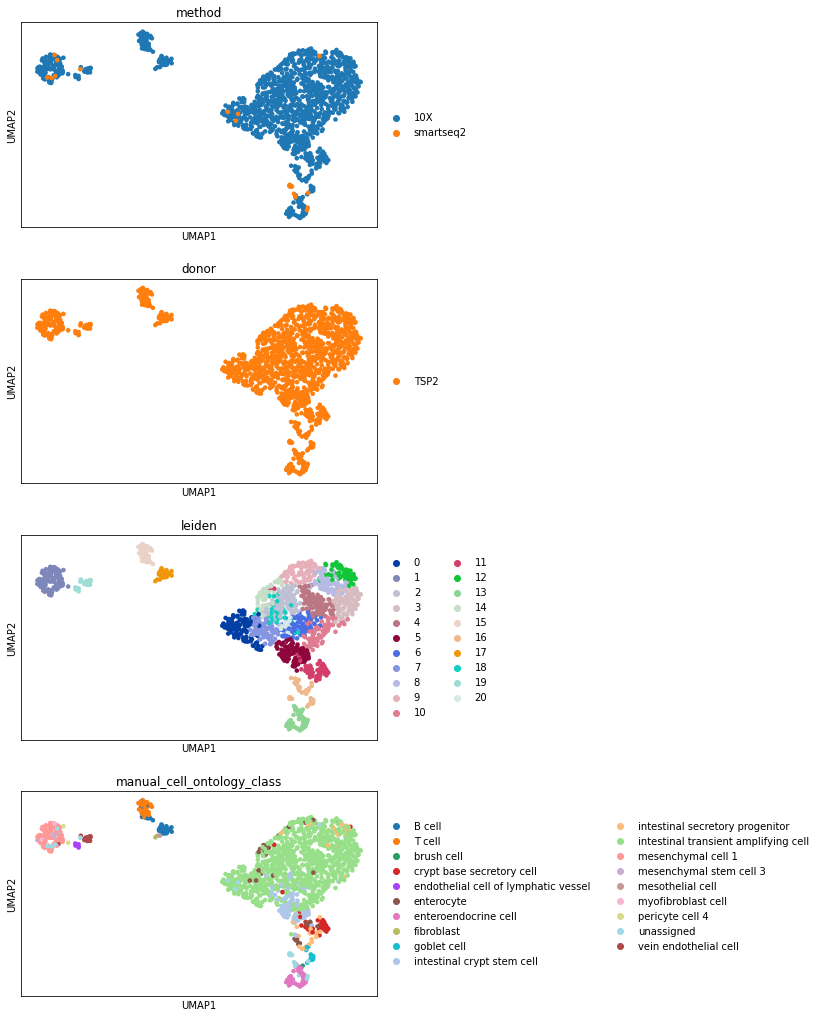

In [5]:
organ = "Large_Intestine"
organ_adata = adata[adata.obs["tissue"] == organ]
sc.pp.neighbors(organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(organ_adata)
organ_adata.obsm["X_umap_decontX"] = organ_adata.obsm["X_umap"].copy()
sc.tl.leiden(organ_adata, resolution=2)
sc.pl.umap(
    organ_adata,
    color=["method", "donor", "leiden", "manual_cell_ontology_class"],
    ncols=1,
)
organ_adata.X = np.log1p(organ_adata.X)

# cluster to celltype correspondance
count is a matrix of cluster-cell type correspondance, where each row is a celltype, and each colum is a cluster. The entries to the matrix is the number of cells that is annotated as celltype *X* and cluster *Y*

In [6]:
count = {}
for c in np.unique(organ_adata.obs["leiden"]):
    count[c] = {}
    for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
        count[c][t] = np.sum(
            (organ_adata.obs["leiden"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )

count = pd.DataFrame.from_dict(count)

We can visualize the cluster assignment of each cell type through this heatmap. The color is normalized for each celltype 

<AxesSubplot:>

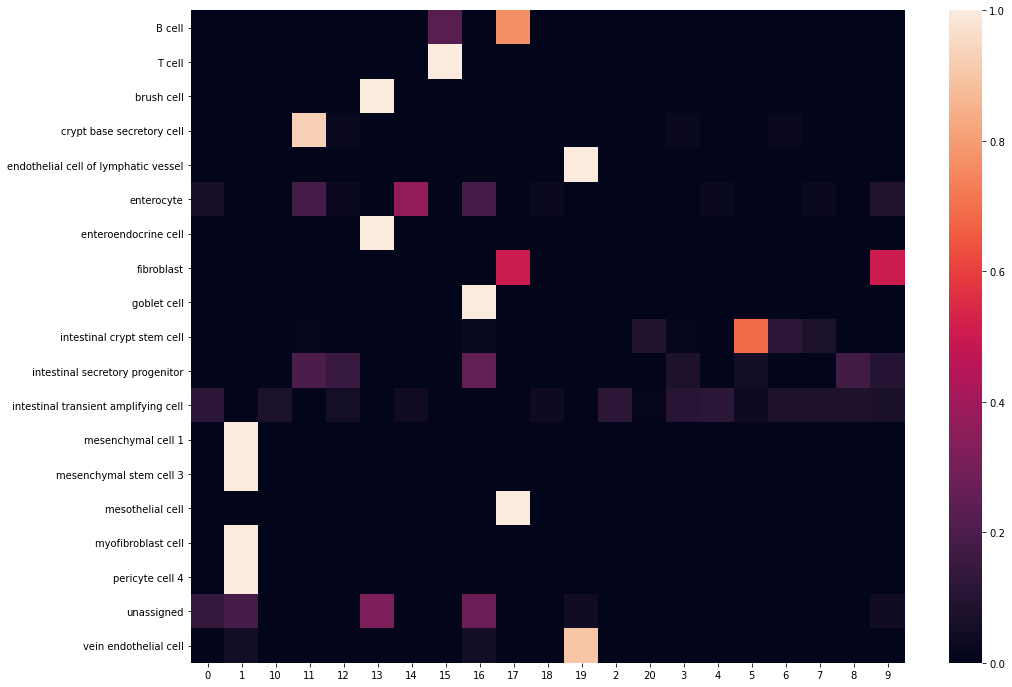

In [7]:
import seaborn

plt.figure(figsize=(16, 12))
seaborn.heatmap((count.T / count.sum(axis=1)).T)

# dictionary of cell type composition of each cluster 
What are clusters previously annotated as 

In [8]:
cluster_composition = {}
for x in count.columns.values:
    t = count.index[count[x] > 0].values
    freq = np.asarray([count.loc[y, x] for y in t]) / count[x].sum()
    res = [a + ": %.2f" % b for a, b in zip(t, freq)]
    cluster_composition[x] = res

In [9]:
cluster_composition["0"]

['enterocyte: 0.02',
 'intestinal transient amplifying cell: 0.96',
 'unassigned: 0.03']

# Reassign pure clusters
If a cluster is very pure (>95% of annotated cells come from the same celltype, we reassign the clusters to all have the same labels) 

In [10]:
def Purity(x):
    names = x.index
    x = np.asarray(x).ravel()
    x = x[names != "unassigned"]
    return (np.max(x) / np.sum(x), names[np.argmax(x)])

In [11]:
cluster_purity = count.apply(Purity, axis=0).T
confident_clusters = cluster_purity[cluster_purity[0] > 0.95].index

In [12]:
for i in confident_clusters:
    organ_adata.obs.loc[
        organ_adata.obs["leiden"] == i, "new_manual_cell_ontology_class"
    ] = cluster_purity.loc[i, 1]

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'new_manual_cell_ontology_class' as categorical


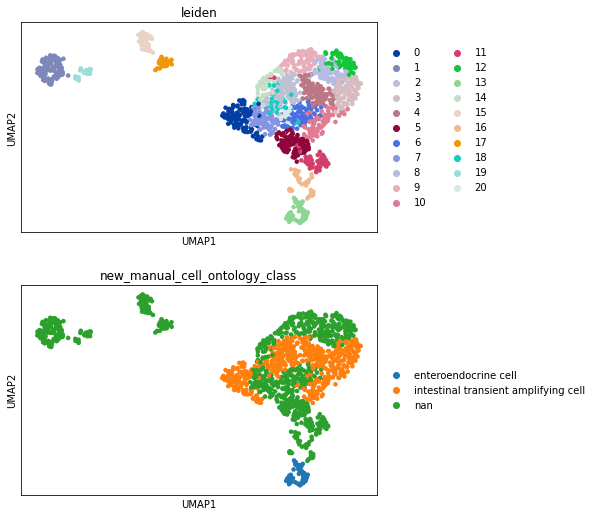

In [13]:
sc.pl.umap(
    organ_adata,
    color=["leiden", "new_manual_cell_ontology_class"],
    ncols=1,
)

In [14]:
organ_adata.obs.groupby(["leiden"]).agg(
    {"new_manual_cell_ontology_class": set, "Propagated.Annotation": set}
)

new_manual_cell_ontology_class  \
leiden                                           
0       {intestinal transient amplifying cell}   
1                                        {nan}   
2       {intestinal transient amplifying cell}   
3       {intestinal transient amplifying cell}   
4       {intestinal transient amplifying cell}   
5                                        {nan}   
6                                        {nan}   
7                                        {nan}   
8                                        {nan}   
9                                        {nan}   
10      {intestinal transient amplifying cell}   
11                                       {nan}   
12                                       {nan}   
13                      {enteroendocrine cell}   
14                                       {nan}   
15                                       {nan}   
16                                       {nan}   
17                                       {nan}   
18      {intestinal transient amplifying cell}   
19                                       {nan}   
20                                       {nan}   

                                    Propagated.Annotation  
leiden                                                     
0       {endothelial cell of lymphatic vessel, intesti...  
1       {vein endothelial cell, fibroblast, mesenchyma...  
2       {intestinal transient amplifying cell, crypt b...  
3       {intestinal transient amplifying cell, crypt b...  
4                  {intestinal transient amplifying cell}  
5       {intestinal transient amplifying cell, intesti...  
6       {intestinal transient amplifying cell, crypt b...  
7       {intestinal transient amplifying cell, crypt b...  
8                  {intestinal transient amplifying cell}  
9       {intestinal transient amplifying cell, fibrobl...  
10      {intestinal transient amplifying cell, intesti...  
11      {crypt base secretory cell, intestinal crypt s...  
12      {intestinal transient amplifying cell, crypt b...  
13      {goblet cell, enteroendocrine cell, brush cell...  
14      {intestinal transient amplifying cell, intesti...  
15                                       {B cell, T cell}  
16      {brush cell, goblet cell, vein endothelial cel...  
17                 {B cell, fibroblast, mesothelial cell}  
18                 {intestinal transient amplifying cell}  
19      {vein endothelial cell, endothelial cell of ly...  
20      {intestinal transient amplifying cell, intesti...

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


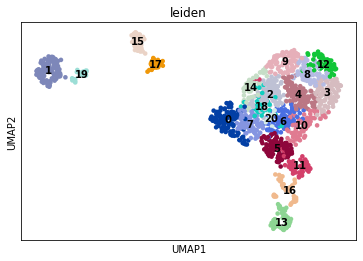

In [15]:
sc.pl.umap(organ_adata, color="leiden", legend_loc="on data")

# Sankey Diagram between cluster and compartment

In [16]:
from utils.colorDict import (
    donor_colors,
    method_colors,
    compartment_colors,
    tissue_colors,
)

In [17]:
from utils.plotting_utils import *
from utils.colorDict import compartment_colors

import plotly
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

import plotly.io as pio

pio.renderers.default = "notebook"

init_notebook_mode(connected=True)

In [18]:
df = pd.DataFrame(columns=["celltype", "compartment", "count"])
for t in np.unique(organ_adata.obs["manual_cell_ontology_class"]):
    for c in np.unique(organ_adata.obs["compartment_pred_svm"]):
        x = np.sum(
            (organ_adata.obs["compartment_pred_svm"].astype(str) == c)
            & (organ_adata.obs["manual_cell_ontology_class"] == t)
        )
        df = df.append(
            pd.DataFrame([t, c, x], index=["celltype", "compartment", "count"]).T,
            ignore_index=True,
        )


fig = genSankey(
    df,
    cat_cols_color=[compartment_colors(), "#00A1E0"],
    cat_cols=["compartment", "celltype"],
    value_cols="count",
    title="celltype-compartment",
)
iplot(fig, validate=False)
plotly.offline.plot(
    fig, validate=False, filename="figures/celltype_sankey_%s" % organ + ".html"
)  # , output_type='div')

'figures/celltype_sankey_Large_Intestine.html'

# visualize compartment markers

In [19]:
compartment_markers = {
    "Epithelial": ["CDH1", "CLDN4", "EPCAM"],
    "Endothelial": ["CA4", "CDH5", "CLDN5", "PECAM1", "VWF"],
    "Stromal": ["BGN", "DCN", "COL1A2"],
    "Immune": ["LCP1", "PTPRC", "RAC2"],
}

In [20]:
for x in compartment_markers.keys():
    sc.tl.score_genes(organ_adata, compartment_markers[x], score_name="%s_score" % x)

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



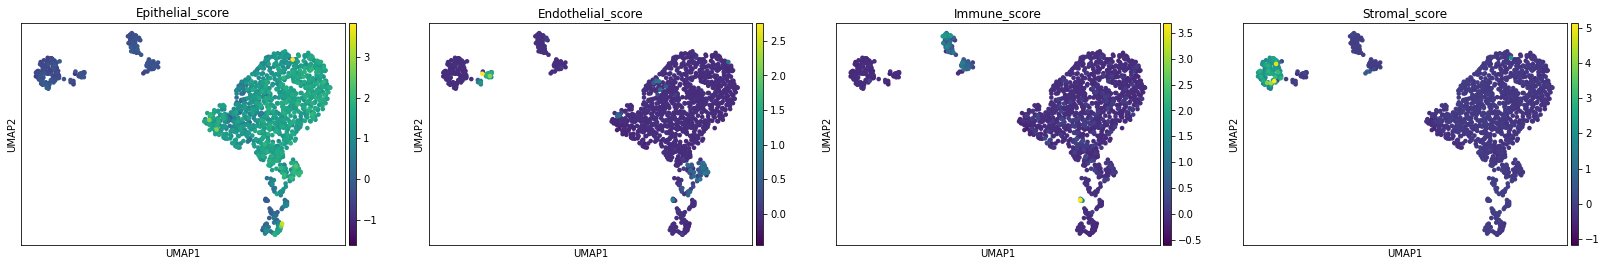

In [21]:
sc.pl.umap(
    organ_adata,
    color=["Epithelial_score", "Endothelial_score", "Immune_score", "Stromal_score"],
)

# Find markers for each cluster

In [22]:
sc.tl.rank_genes_groups(organ_adata, groupby="leiden", method="wilcoxon")

In [23]:
def FormatDE(res):
    groups = res['scores'].dtype.names
    df_res = {}
    for group in groups:
        df = pd.DataFrame([res['scores'][group],
                           res['logfoldchanges'][group],res['pvals_adj'][group]], 
                           columns=res['names'][group],
                           index=['wilcoxon_score','log fold change','adjusted pvalue'])
        df_res[group] = df
    return df_res


In [24]:
DE = FormatDE(organ_adata.uns["rank_genes_groups"])

### top positive marker genes

In [25]:
organ_cluster_genes = pd.DataFrame(organ_adata.uns['rank_genes_groups']['names'])
organ_cluster_genes.iloc[:20]


0         1         2        3        4         5         6       7  \
0   TUBA1B      GPX3       CA2      EZR    FXYD3   SLC12A2      RPL5  RANBP1   
1    STMN1     TIMP1     ADH1C     LDLR     CES2      CDK6     RACK1   RPL36   
2    H2AFZ       DCN  C19orf33     IER3     PIGR      RGMB     RPL12   STMN1   
3     TUBB       VIM     ADIRF     EDN1    MGST3      ETS2      GAS5   RPL39   
4    HMGB2       C1R     FABP1     AREG  SLC26A2      TFF3     RPL13   CDCA7   
5    HMGN2       C1S    SNHG29   PHLDA2      TXN      KLK1    LEFTY1    LDHB   
6    HMGB1     TIMP2       CKB      SFN  S100A14      SOX4      RPL3   PRDX5   
7      TK1    LGALS1    LGALS4   GPRC5A  ATP5F1C     EPHB3     RPL14   RPL35   
8   MAD2L1       GSN     GAPDH  HERPUD1    CDH17    MT-ND3      RPS2   SNRPB   
9    CENPW     TIMP3  C15orf48    MUC13   LGALS4     ITGA6     RPL18   RPS18   
10    SMC2       CFD    UQCR10   SQSTM1     NANS     ASCL2  MARCKSL1   RPL26   
11   MKI67       MGP   ABHD14B    TRIB1  UGT2B17   ALDH1B1    RPL35A   HMGA1   
12  NUCKS1     FSTL1    PYCARD     CD55     PCK1     EDIL3     RPL15   RPL13   
13   LMNB1    IGFBP6     PHGR1     MAFF     CD24  MARCKSL1    SNHG29   RPL34   
14    SMC4     MFGE8      EIF6    ARL14   HMGCS2     CDCA7    RPL10A   RPL37   
15   ZWINT     CALD1     EIF3K    NCOA7   ATP5MD   CEACAM5      RPS9  TUBA1B   
16   DTYMK  SERPING1      NANS     TOB1   PYCARD   MT-ND4L     RPL10   RPL12   
17    TPX2  SERPINF1    COMMD6     MIDN    COX5B      GAS5    EEF1B2   RPL32   
18   CKS1B     FBLN1     PRSS3    SRSF5   LGALS3     PRDX5      BTF3     DUT   
19    PTMA     MFAP5    MRPL23  SERTAD1    PRSS3     RPL31     RPLP1   RPS24   

           8         9  ...        11        12        13          14  \
0        CA2     FABP1  ...      SPIB       CA2    PCSK1N       FABP1   
1    SLC26A2       CA2  ...       LYZ   SLC26A2      SCGN         CA2   
2      FABP1   SLC26A2  ...       CA7     FABP1    CRYBA2       NOXO1   
3       CES2  SELENBP1  ...    NEURL1    CLDN23      SCG5      LGALS2   
4      FXYD3   SLC26A3  ...  HEPACAM2   SULT1B1     MS4A8       FXYD3   
5     ATP1A1   HSD11B2  ...       CA4      CES2      SCG2       HDHD3   
6    UGT2B17    TSPAN1  ...      MSLN     KRT19   MT-RNR2     DENND2A   
7   SELENBP1       CA1  ...     BEST4  SELENBP1   CACNA1A        SDSL   
8      CDH17     KRT19  ...     PROX1   SLC26A3       FEV        LCN2   
9    HSD11B2     FXYD3  ...   CEACAM5    ATP1A1       SCT   LINC02313   
10      CD24     PHGR1  ...    NOTCH2    TSPAN1       CPE  SLC22A18AS   
11      PIGR       CKB  ...     KRT20     PADI2      PCLO       OPLAH   
12     KRT19       TST  ...      SCIN    PAPSS2      CHGA      ATP5MF   
13      MPC1   SULT1A1  ...      RHOV      KLF6     RAB3B      FBXL15   
14      PKIB    MRPL41  ...     LYPD8    ATP1B3    MALAT1        AOC1   
15    TSPAN1      CES2  ...   CEACAM6      CD24      CHGB      NDUFA2   
16     PHGR1   AKR1B10  ...     UNC5C   C2orf88  MIR7-3HG         TST   
17    LGALS4    ATP1A1  ...    SDCBP2     HSPA5     NPDC1    PDZK1IP1   
18   SULT1A1    SCNN1B  ...     DMBT1     PANK3   MT-RNR1  AP000439.2   
19     CLDN7      CTSD  ...      HES4      TDP2       PYY     MICOS13   

           15        16         17         18       19          20  
0        SRGN  HEPACAM2     LAPTM5       ITPA   CAVIN2        IER3  
1        CD3E    NEURL1      CXCR4    RARRES1     CAV1  AP003498.2  
2       CXCR4  SERPINA1    TSC22D3       SEM1    EGFL7       EPHA2  
3        RGS1      MUC2       CD37      SNORC   PECAM1        EDN1  
4       CYTIP     BEST2      CD79A      PSMA5    CLDN5        HES4  
5        CD69      ZG16    MT-RNR2      SLIRP   GIMAP7        HES1  
6   LINC-PINT     REP15       CD74     MRPS28    HLA-E      NFKBIA  
7     ARHGDIB     FCGBP       CD83      PYCR1    CRIP2       RASD1  
8       PTPRC       CA4       CD52      NUDT8     LMO2     ZC3H12A  
9        CCL5     ITLN1    MT-RNR1       PHB2   TGFBR2        CDK6  
10       CD53     BEST4  TNFRSF13C 

In [26]:
for x in DE.keys():
    print(x)
    display(DE[x].T[:20])

0


wilcoxon_score  log fold change  adjusted pvalue
TUBA1B       16.307011         3.670423     3.002724e-55
STMN1        16.297977         4.771872     3.002724e-55
H2AFZ        16.066078         3.386778     8.656378e-54
TUBB         15.515867         3.411469     3.987722e-50
HMGB2        15.435991         3.796591     1.103793e-49
HMGN2        15.372639         3.095781     2.450825e-49
HMGB1        15.346607         2.514786     3.138601e-49
TK1          15.317011         5.509581     4.331567e-49
MAD2L1       15.046838         4.618272     2.368760e-47
CENPW        14.744453         4.605762     1.966332e-45
SMC2         14.639499         4.047942     8.414320e-45
MKI67        14.508156         6.769808     5.277372e-44
NUCKS1       14.306566         2.237372     9.016320e-43
LMNB1        14.254624         3.770172     1.764235e-42
SMC4         14.211001         3.433945     3.072918e-42
ZWINT        14.101054         4.235301     1.376592e-41
DTYMK        13.949030         3.590454     1.104376e-40
TPX2         13.891501         5.087284     2.332717e-40
CKS1B        13.859528         3.280246     3.451817e-40
PTMA         13.812576         2.114544     6.300158e-40

1


wilcoxon_score  log fold change  adjusted pvalue
GPX3           17.320490        11.046900     1.940022e-62
TIMP1          17.246910         6.512142     3.474714e-62
DCN            17.184595        13.136736     6.796749e-62
VIM            17.054932         7.142828     4.728022e-61
C1R            17.027128        11.527366     5.154234e-61
C1S            17.026171        11.034700     5.154234e-61
TIMP2          16.991898         9.009380     7.929780e-61
LGALS1         16.983028         8.940995     8.070826e-61
GSN            16.968409         7.769862     9.202863e-61
TIMP3          16.909090         8.959233     2.270137e-60
CFD            16.878172        13.881277     3.368453e-60
MGP            16.868225        12.237964     3.368453e-60
FSTL1          16.867506        10.292212     3.368453e-60
IGFBP6         16.865948        12.862797     3.368453e-60
MFGE8          16.838026         8.862119     5.041213e-60
CALD1          16.807827         8.281912     7.868947e-60
SERPING1       16.787455         8.604105     1.044068e-59
SERPINF1       16.724182        11.971614     2.857425e-59
FBLN1          16.720467        12.869860     2.881170e-59
MFAP5          16.713757        12.635779     3.063285e-59

2


wilcoxon_score  log fold change  adjusted pvalue
CA2             5.926964         1.394162         0.000045
ADH1C           5.832270         1.256399         0.000063
C19orf33        5.518817         0.986390         0.000223
ADIRF           5.337229         0.947580         0.000427
FABP1           5.322726         1.902485         0.000430
SNHG29          5.282874         1.023625         0.000475
CKB             5.234491         1.095749         0.000518
LGALS4          5.231810         1.777707         0.000518
GAPDH           5.154666         0.993671         0.000680
C15orf48        5.130535         1.482920         0.000700
UQCR10          5.065578         0.914931         0.000856
ABHD14B         4.983680         0.764944         0.001185
PYCARD          4.926157         0.808951         0.001496
PHGR1           4.885574         1.451700         0.001764
EIF6            4.882284         0.724861         0.001764
EIF3K           4.864856         0.783633         0.001873
NANS            4.838776         0.927133         0.002020
COMMD6          4.787833         0.615880         0.002402
PRSS3           4.785396         0.806929         0.002402
MRPL23          4.760778         0.678176         0.002523

3


wilcoxon_score  log fold change  adjusted pvalue
EZR           13.282709         2.169346     1.716926e-35
LDLR          12.938128         2.457227     8.072063e-34
IER3          12.517080         2.674155     1.181512e-31
EDN1          12.446148         2.841832     2.159936e-31
AREG          12.282523         2.846777     1.125196e-30
PHLDA2        12.280925         2.514531     1.125196e-30
SFN           12.165490         2.624383     3.991263e-30
GPRC5A        12.057432         2.334870     1.304137e-29
HERPUD1       11.971870         2.000916     3.263427e-29
MUC13         11.856559         1.905515     1.171430e-28
SQSTM1        11.817712         1.711022     1.692131e-28
TRIB1         11.791773         2.137780     2.111391e-28
CD55          11.701294         2.055574     5.684331e-28
MAFF          11.610200         2.023016     1.538010e-27
ARL14         11.526114         2.426228     3.824340e-27
NCOA7         11.369374         2.170660     2.128131e-26
TOB1          11.366424         1.855588     2.128131e-26
MIDN          11.355114         1.864548     2.287719e-26
SRSF5         11.309997         1.659936     3.628051e-26
SERTAD1       11.302252         1.870592     3.764597e-26

4


wilcoxon_score  log fold change  adjusted pvalue
FXYD3          9.483109         2.098030     1.453019e-16
CES2           9.095516         1.806993     2.770955e-15
PIGR           8.880297         2.331894     1.032316e-14
MGST3          8.865726         1.304709     1.032316e-14
SLC26A2        8.849798         2.054975     1.032316e-14
TXN            8.775219         1.624064     1.673597e-14
S100A14        8.753487         1.477797     1.739694e-14
ATP5F1C        8.737311         1.292577     1.756709e-14
CDH17          8.690144         1.362255     2.367767e-14
LGALS4         8.571853         2.202799     5.994909e-14
NANS           8.525673         1.410798     8.130700e-14
UGT2B17        8.500978         1.674701     9.222999e-14
PCK1           8.484925         1.868921     9.774987e-14
CD24           8.429237         1.756016     1.443617e-13
HMGCS2         8.419853         1.422984     1.443617e-13
ATP5MD         8.415161         1.284331     1.443617e-13
PYCARD         8.347990         1.287303     2.404467e-13
COX5B          8.339841         1.322083     2.432984e-13
LGALS3         8.327864         1.555680     2.550440e-13
PRSS3          8.286499         1.273340     3.433020e-13

5


wilcoxon_score  log fold change  adjusted pvalue
SLC12A2        14.010661         3.119776     7.897445e-40
CDK6           13.587497         3.084821     1.398320e-37
RGMB           13.032456         3.153825     1.569681e-34
ETS2           12.524785         2.258350     8.041513e-32
TFF3           12.324066         2.710904     7.914200e-31
KLK1           11.743258         3.214614     7.504261e-28
SOX4           11.631340         2.412086     2.401731e-27
EPHB3          11.227375         3.252385     1.957333e-25
MT-ND3         11.092847         1.499290     8.000007e-25
ITGA6          10.609303         1.856885     1.443680e-22
ASCL2          10.566355         4.812882     2.093626e-22
ALDH1B1        10.471237         2.357845     5.302933e-22
EDIL3          10.430184         2.223191     7.591639e-22
MARCKSL1       10.129295         1.556841     1.507041e-20
CDCA7           9.821585         2.285305     2.973029e-19
CEACAM5         9.775100         1.843571     4.462189e-19
MT-ND4L         9.738847         1.062738     6.059996e-19
GAS5            9.677961         1.387756     1.048726e-18
PRDX5           9.616697         1.577451     1.819046e-18
RPL31           9.404610         1.367998     1.336694e-17

6


wilcoxon_score  log fold change  adjusted pvalue
RPL5            8.145741         1.318891     2.219213e-11
RACK1           8.037752         1.223726     2.693350e-11
RPL12           7.960795         1.209145     3.322376e-11
GAS5            7.926316         1.240803     3.322376e-11
RPL13           7.779435         1.135994     8.577257e-11
LEFTY1          7.733095         1.781474     1.029859e-10
RPL3            7.664275         1.183861     1.512489e-10
RPL14           7.536703         1.074807     3.546944e-10
RPS2            7.519187         1.273372     3.605315e-10
RPL18           7.435748         1.119349     6.121176e-10
MARCKSL1        7.404165         1.290828     6.493735e-10
RPL35A          7.392581         1.058048     6.493735e-10
RPL15           7.391477         1.171046     6.493735e-10
SNHG29          7.380444         1.332937     6.493735e-10
RPL10A          7.374100         1.203878     6.493735e-10
RPS9            7.352723         1.069685     7.059533e-10
RPL10           7.346241         1.132242     7.059533e-10
EEF1B2          7.301280         1.273427     9.322497e-10
BTF3            7.285144         1.052699     9.956086e-10
RPLP1           7.276869         1.128005     1.005669e-09

7


wilcoxon_score  log fold change  adjusted pvalue
RANBP1        9.079504         1.682212     6.420971e-15
RPL36         8.969046         1.217810     8.803841e-15
STMN1         8.822797         2.438168     1.417047e-14
RPL39         8.819148         1.309979     1.417047e-14
CDCA7         8.814376         2.336493     1.417047e-14
LDHB          8.702374         1.639993     3.188941e-14
PRDX5         8.680057         1.624168     3.268662e-14
RPL35         8.666863         1.135381     3.268662e-14
SNRPB         8.648758         1.364518     3.405501e-14
RPS18         8.524405         1.388709     9.042346e-14
RPL26         8.510930         1.261432     9.234222e-14
HMGA1         8.410015         1.578426     2.011178e-13
RPL13         8.337172         1.209160     3.445638e-13
RPL34         8.303347         1.135127     4.256267e-13
RPL37         8.287346         1.184089     4.544895e-13
TUBA1B        8.268679         1.609634     4.983767e-13
RPL12         8.247626         1.269302     5.595153e-13
RPL32         8.209028         1.195850     7.292858e-13
DUT           8.192467         1.612292     7.929665e-13
RPS24         8.136045         1.253062     1.202132e-12

8


wilcoxon_score  log fold change  adjusted pvalue
CA2            10.330095         3.152719     2.107676e-20
SLC26A2        10.298451         2.967828     2.107676e-20
FABP1           9.619263         3.643391     1.301125e-17
CES2            9.580283         2.172985     1.424351e-17
FXYD3           9.415735         2.366050     5.531207e-17
ATP1A1          9.390133         1.871938     5.879602e-17
UGT2B17         9.261113         2.025288     1.701449e-16
SELENBP1        9.176970         2.061030     3.262832e-16
CDH17           8.887573         1.668673     4.085461e-15
HSD11B2         8.859813         1.789119     4.718368e-15
CD24            8.804580         2.003252     7.029260e-15
PIGR            8.656286         2.485500     2.391028e-14
KRT19           8.549129         2.087180     5.616242e-14
MPC1            8.376239         1.533995     2.297859e-13
PKIB            8.285767         1.800159     4.605619e-13
TSPAN1          8.272534         1.707974     4.825189e-13
PHGR1           8.218164         2.058915     7.155886e-13
LGALS4          8.153583         2.312057     1.155487e-12
SULT1A1         8.128986         1.648174     1.341290e-12
CLDN7           8.081233         1.578371     1.887227e-12

9


wilcoxon_score  log fold change  adjusted pvalue
FABP1          10.939121         4.305277     4.410704e-23
CA2            10.816815         3.532902     8.434934e-23
SLC26A2        10.539511         3.183396     1.114477e-21
SELENBP1        9.460460         2.351457     4.512270e-17
SLC26A3         9.429846         3.435529     4.835470e-17
HSD11B2         9.354502         2.137180     8.241303e-17
TSPAN1          9.201731         2.188004     2.591962e-16
CA1             9.105135         3.452390     5.635758e-16
KRT19           9.071549         2.461458     6.907586e-16
FXYD3           9.044502         2.352755     8.046350e-16
PHGR1           8.644001         2.300346     2.662793e-14
CKB             8.435205         2.184559     1.497211e-13
TST             8.059075         1.660401     3.232541e-12
SULT1A1         8.018950         1.763789     4.185744e-12
MRPL41          7.967978         1.493968     5.888725e-12
CES2            7.961439         1.908775     5.888725e-12
AKR1B10         7.910020         2.188739     8.416676e-12
ATP1A1          7.788458         1.749807     2.025004e-11
SCNN1B          7.786674         1.983814     2.025004e-11
CTSD            7.706872         1.411139     3.614603e-11

10


wilcoxon_score  log fold change  adjusted pvalue
HNRNPU         9.024864         1.556926     1.059182e-14
PABPC1         8.938062         1.483382     1.165793e-14
RPL31          8.734656         1.458179     4.795907e-14
NCL            8.487391         1.534048     3.110208e-13
EEF2           8.418927         1.273303     4.473494e-13
RPL13A         8.263814         1.325562     1.384335e-12
EIF4A2         8.204213         1.268033     1.756464e-12
RPS17          8.200851         1.492936     1.756464e-12
EIF3A          8.099989         1.522581     3.595259e-12
RPL7           8.011659         1.366087     6.662420e-12
RPS20          7.947932         1.286899     9.524492e-12
RPS11          7.945028         1.263738     9.524492e-12
IRF2BP2        7.897348         1.453805     1.290157e-11
RPS8           7.839123         1.281778     1.907822e-11
SLC12A2        7.808406         1.889717     2.272998e-11
RPS16          7.778300         1.249942     2.704539e-11
KLF5           7.717783         1.547529     4.022557e-11
RPS29          7.703571         1.252020     4.022557e-11
TM9SF3         7.702195         1.292323     4.022557e-11
MALAT1         7.699445         1.650200     4.022557e-11

11


wilcoxon_score  log fold change  adjusted pvalue
SPIB           11.911199         7.289392     6.091798e-28
LYZ            11.627810         6.934381     8.760960e-27
CA7            11.116922         8.649037     2.036727e-24
NEURL1         10.878115         5.637396     2.157040e-23
HEPACAM2       10.232171         5.078123     1.675363e-20
CA4             9.959107         7.760530     2.257854e-19
MSLN            9.927802         6.892493     2.650206e-19
BEST4           9.896333         7.165251     3.177666e-19
PROX1           9.717350         4.883359     1.663500e-18
CEACAM5         9.633431         2.737361     3.400783e-18
NOTCH2          9.340044         3.549885     4.724039e-17
KRT20           9.298576         4.622485     6.445766e-17
SCIN            8.797031         3.736810     5.907316e-15
RHOV            8.655582         2.968394     1.924659e-14
LYPD8           8.567566         6.486059     3.888915e-14
CEACAM6         8.448408         5.353549     1.022609e-13
UNC5C           8.368587         6.198381     1.745077e-13
SDCBP2          8.368095         2.262803     1.745077e-13
DMBT1           8.360884         6.253760     1.745077e-13
HES4            8.327284         2.489316     2.213468e-13

12


wilcoxon_score  log fold change  adjusted pvalue
CA2            11.325735         4.103400     5.760685e-25
SLC26A2        10.709949         3.736912     2.690699e-22
FABP1          10.605543         4.569592     5.510777e-22
CLDN23          9.773405         2.670186     2.155321e-18
SULT1B1         9.667687         2.335398     4.869970e-18
CES2            9.609993         2.398947     7.118756e-18
KRT19           9.537711         2.744323     9.180060e-18
SELENBP1        9.535253         2.560654     9.180060e-18
SLC26A3         9.530828         3.935230     9.180060e-18
ATP1A1          9.529024         2.239920     9.180060e-18
TSPAN1          9.520993         2.382689     9.180060e-18
PADI2           9.449368         2.307235     1.672323e-17
PAPSS2          9.355123         2.283977     3.781383e-17
KLF6            9.346272         2.224033     3.817780e-17
ATP1B3          9.334144         2.083654     3.995755e-17
CD24            9.295626         2.335434     5.282986e-17
C2orf88         9.291201         2.806949     5.282986e-17
HSPA5           9.214985         2.187502     1.018192e-16
PANK3           9.202037         1.929981     1.088251e-16
TDP2            9.112218         1.985710     2.276423e-16

13


wilcoxon_score  log fold change  adjusted pvalue
PCSK1N         10.640541        11.210746     4.340876e-23
SCGN            9.752052        31.621031     8.943121e-20
CRYBA2          9.298469        31.643946     4.738985e-18
SCG5            9.268053         9.404298     6.165891e-18
MS4A8           9.148211         4.274935     1.712393e-17
SCG2            8.838603        11.343472     2.189385e-16
MT-RNR2         8.774962         2.127074     3.633383e-16
CACNA1A         8.160377        12.013228     4.626250e-14
FEV             7.937717        30.526356     2.504856e-13
SCT             7.710925        30.482225     1.349248e-12
CPE             7.630919         5.515582     2.390543e-12
PCLO            7.374704         2.592800     1.484915e-11
CHGA            7.257341        32.779758     3.315308e-11
RAB3B           7.239489         9.348513     3.750191e-11
MALAT1          7.158492         1.578807     6.497976e-11
CHGB            7.030549        30.329741     1.558670e-10
MIR7-3HG        7.030549        29.444065     1.558670e-10
NPDC1           6.934675         2.523357     2.930229e-10
MT-RNR1         6.907731         1.531461     3.501388e-10
PYY             6.799294        14.832127     7.122184e-10

14


wilcoxon_score  log fold change  adjusted pvalue
FABP1             3.805334         1.825424         0.010757
CA2               2.964872         1.012453         0.114418
NOXO1             2.822403         0.887619         0.160163
LGALS2            2.580518         0.724042         0.274205
FXYD3             2.498218         0.967813         0.325138
HDHD3             2.255813         0.539724         0.526254
DENND2A           2.211724         0.618952         0.569001
SDSL              2.206191         0.804808         0.575253
LCN2              2.205499         0.579491         0.575253
LINC02313         2.184406         1.928207         0.597528
SLC22A18AS        2.050063         0.565384         0.753056
OPLAH             2.029143         1.073217         0.775261
ATP5MF            1.991969         0.534777         0.826290
FBXL15            1.920735         0.470760         0.928578
AOC1              1.914510         0.464150         0.936307
NDUFA2            1.860220         0.407775         1.000000
TST               1.820281         0.532228         1.000000
PDZK1IP1          1.799187         0.414784         1.000000
AP000439.2        1.781724         1.069829         1.000000
MICOS13           1.713429         0.385134         1.000000

15


wilcoxon_score  log fold change  adjusted pvalue
SRGN            11.573672         7.444205     3.298586e-26
CD3E            10.809762        31.491499     3.643740e-23
CXCR4           10.672859         6.568147     1.146825e-22
RGS1            10.478810         8.136347     5.302946e-22
CYTIP           10.426292         7.156826     8.517313e-22
CD69            10.330515         6.804923     1.886958e-21
LINC-PINT       10.217824         3.858594     4.223371e-21
ARHGDIB         10.153378         4.872354     6.179205e-21
PTPRC           10.097122         6.107258     8.813027e-21
CCL5            10.071308        13.935739     1.062351e-20
CD53             9.863374         6.293115     5.463057e-20
TSC22D3          9.857677         3.745146     5.664172e-20
IL32             9.808186         6.244429     8.259213e-20
MT-RNR2          9.630158         2.208629     3.134683e-19
TNFAIP3          9.488627         3.810343     9.439175e-19
MT-RNR1          9.385372         1.847485     2.121161e-18
KLRB1            9.335703        31.731308     3.108432e-18
CD52             9.298495         5.923003     4.130957e-18
IL7R             8.834558        11.240920     1.657166e-16
LCP1             8.644960         5.584451     7.284150e-16

16


wilcoxon_score  log fold change  adjusted pvalue
HEPACAM2        5.384969         3.822392         0.000002
NEURL1          4.641868         2.889686         0.000067
SERPINA1        3.845403         6.350319         0.001812
MUC2            3.653408         8.202000         0.003676
BEST2           3.641634         7.046640         0.003825
ZG16            3.630809         7.442787         0.003973
REP15           3.598715         6.401321         0.004458
FCGBP           3.564342         7.061965         0.005014
CA4             3.460844         3.079367         0.007159
ITLN1           3.369499         5.748466         0.009718
BEST4           3.255365         3.726784         0.014116
TPSG1           3.103631         6.328713         0.022707
OTOP2           3.055774         3.372737         0.026184
CA7             3.045330         2.805116         0.026977
RAP1GAP         3.044760         4.967491         0.027012
DLL1            3.028808         5.400052         0.028369
KRT20           3.001461         1.766508         0.030804
ANO7            3.000132         4.715673         0.030932
KCNMA1          2.868527         6.248862         0.045260
RETNLB          2.852575         4.717332         0.047278

17


wilcoxon_score  log fold change  adjusted pvalue
LAPTM5           8.779485         6.375842     2.399765e-14
CXCR4            8.723535         6.909052     2.399765e-14
TSC22D3          8.513615         3.645614     7.608799e-14
CD37             8.489911         6.388029     7.608799e-14
CD79A            8.341280        31.484406     1.442137e-13
MT-RNR2          8.208451         2.336386     2.748000e-13
CD74             8.164674         4.746162     3.449847e-13
CD83             8.161257         6.328444     3.485493e-13
CD52             8.118760         6.160061     4.332194e-13
MT-RNR1          8.090358         1.892275     5.003084e-13
TNFRSF13C        8.033980         9.933781     6.798006e-13
HLA-DRA          7.965004         7.426590     1.054568e-12
MS4A1            7.745474        30.856634     3.521433e-12
HLA-DPA1         7.629089         6.536189     7.403170e-12
LINC-PINT        7.226760         3.375411     9.016028e-11
CD69             7.168461         5.858978     1.313246e-10
BANK1            7.098416         7.623126     2.052233e-10
GPR183           7.067024         7.317277     2.525369e-10
KLF2             6.973062         2.701477     4.452810e-10
FCMR             6.963666         5.735092     4.725715e-10

18


wilcoxon_score  log fold change  adjusted pvalue
ITPA             3.648640         0.968370         0.658091
RARRES1          3.532970         1.061192         0.733055
SEM1             3.296932         0.722612         1.000000
SNORC            3.180590         1.097126         1.000000
PSMA5            3.171193         0.868219         1.000000
SLIRP            3.150162         0.824041         1.000000
MRPS28           3.079910         1.083010         1.000000
PYCR1            3.059327         1.251469         1.000000
NUDT8            3.043665         1.022650         1.000000
PHB2             2.955738         0.820549         1.000000
NME1             2.928443         0.805430         1.000000
HNF1A-AS1        2.901148         1.190024         1.000000
IGFBP2           2.894659         1.072763         1.000000
MYDGF            2.892422         0.736657         1.000000
ACTN1            2.855282         0.905794         1.000000
PIH1D1           2.849465         0.890079         1.000000
NDUFB1           2.835146         0.773063         1.000000
PAPSS2           2.834028         0.840545         1.000000
PPP2R1A          2.802705         0.737055         1.000000
CYC1             2.791966         0.907289         1.000000

19


wilcoxon_score  log fold change  adjusted pvalue
CAVIN2         8.395630         9.973224     2.728049e-12
CAV1           8.127327         6.127713     8.920569e-12
EGFL7          8.073570        12.534697     8.920569e-12
PECAM1         8.066371        10.637094     8.920569e-12
CLDN5          8.060851        11.027857     8.920569e-12
GIMAP7         8.026533         8.010301     9.837720e-12
HLA-E          7.952138         3.095197     1.541719e-11
CRIP2          7.627439         6.838958     1.358053e-10
LMO2           7.609920         6.121418     1.358053e-10
TGFBR2         7.608720         4.148466     1.358053e-10
TIMP3          7.294340         4.655616     5.824519e-10
VIM            7.289060         5.043126     5.824519e-10
GNG11          7.120351         5.546154     1.440346e-09
TCF4           7.105951         5.611087     1.563278e-09
GIMAP1         7.015717         7.598881     2.491086e-09
KCTD12         6.988359         3.805877     2.872444e-09
MT-RNR2        6.923323         2.422206     3.935104e-09
IFITM3         6.901484         3.087461     4.207727e-09
STOM           6.898365         4.538968     4.220396e-09
FXYD5          6.897165         4.762941     4.220396e-09

20


wilcoxon_score  log fold change  adjusted pvalue
IER3              3.329085         1.701930         0.548295
AP003498.2        2.928518         1.594113         0.853078
EPHA2             2.896863         1.595161         0.877034
EDN1              2.888875         1.612193         0.882188
HES4              2.766102         1.268948         0.987913
HES1              2.673208         1.459246         1.000000
NFKBIA            2.555760         0.988364         1.000000
RASD1             2.425294         1.706726         1.000000
ZC3H12A           2.386835         1.022997         1.000000
CDK6              2.303113         1.061909         1.000000
MAFF              2.302225         1.018348         1.000000
UBE2S             2.228857         0.889004         1.000000
AC073861.1        2.224419         0.851069         1.000000
BRF2              2.175014         1.408077         1.000000
C6orf222          2.113479         1.170086         1.000000
PPP1R15A          2.105788         0.822718         1.000000
NR4A1             2.099279         0.985990         1.000000
FOSL1             2.089812         1.480684         1.000000
ETS2              2.055199         0.819668         1.000000
TRIB1             2.043069         0.879259         1.000000

### for cluster 0 plot the top marker genes

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



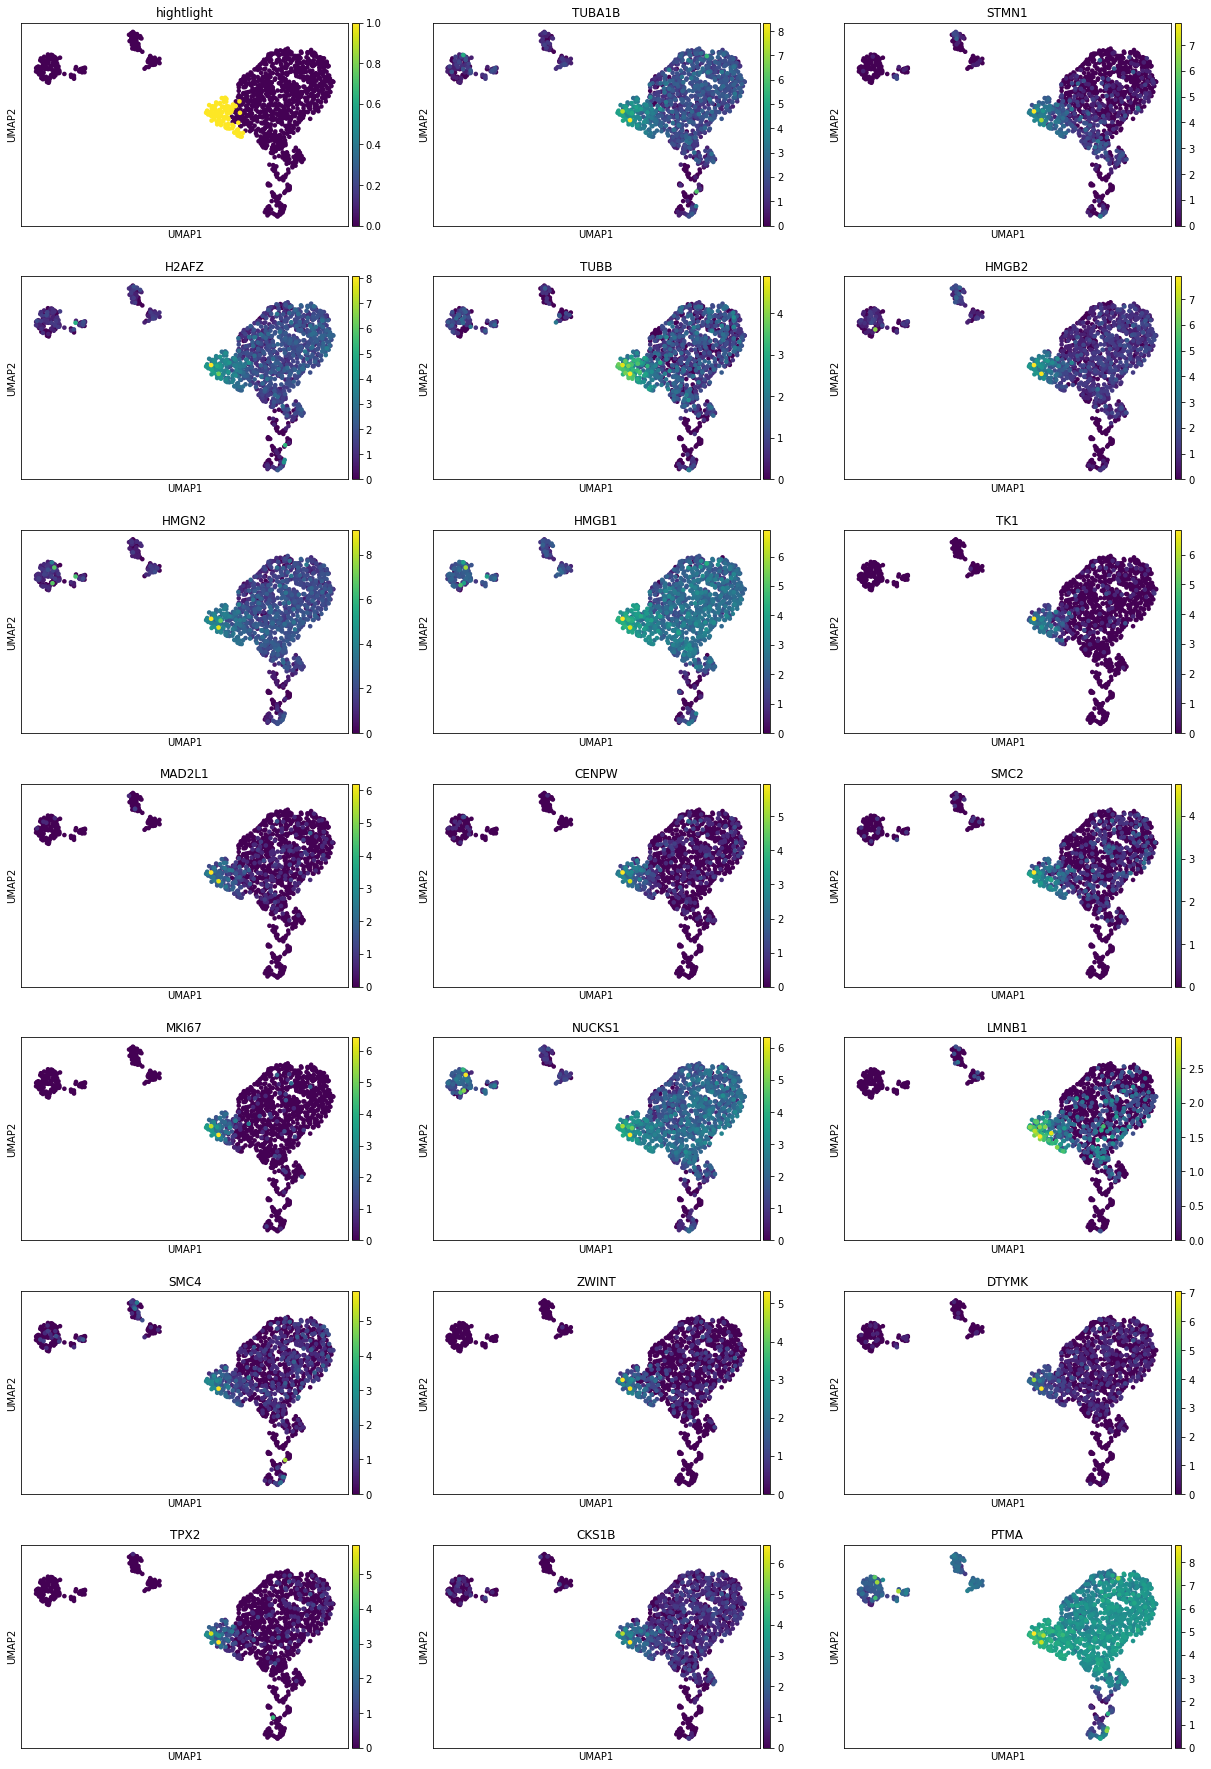

In [27]:
topgenes = list(DE["0"].T[:20].index)
organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == "0"
sc.pl.umap(
    organ_adata,
    color=["hightlight"] + topgenes,
    ncols=3,
)

You can do this for other clusters as well. Here I plot the top 5 genes for all other clusters

0


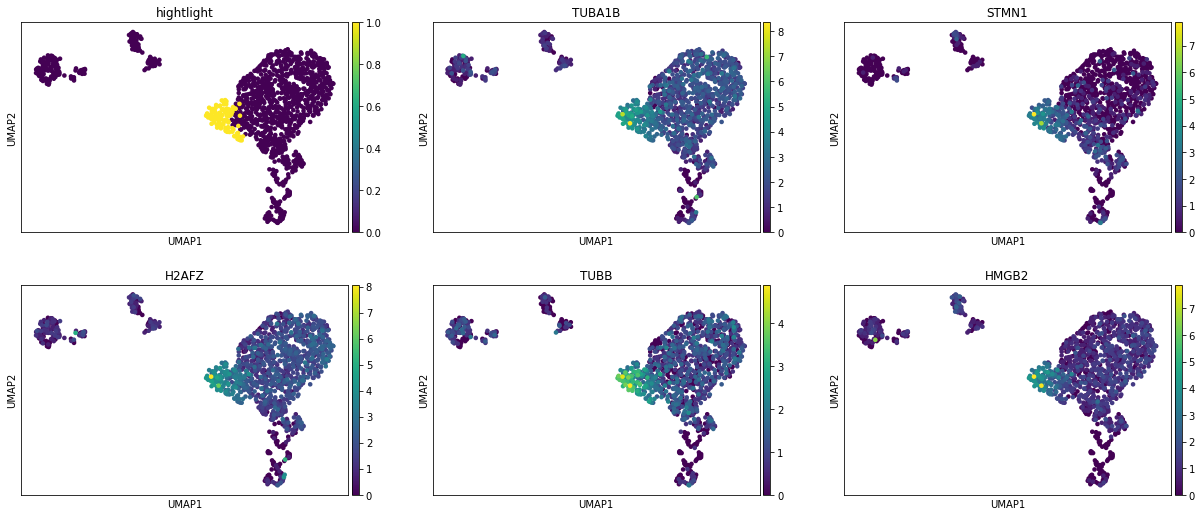

1


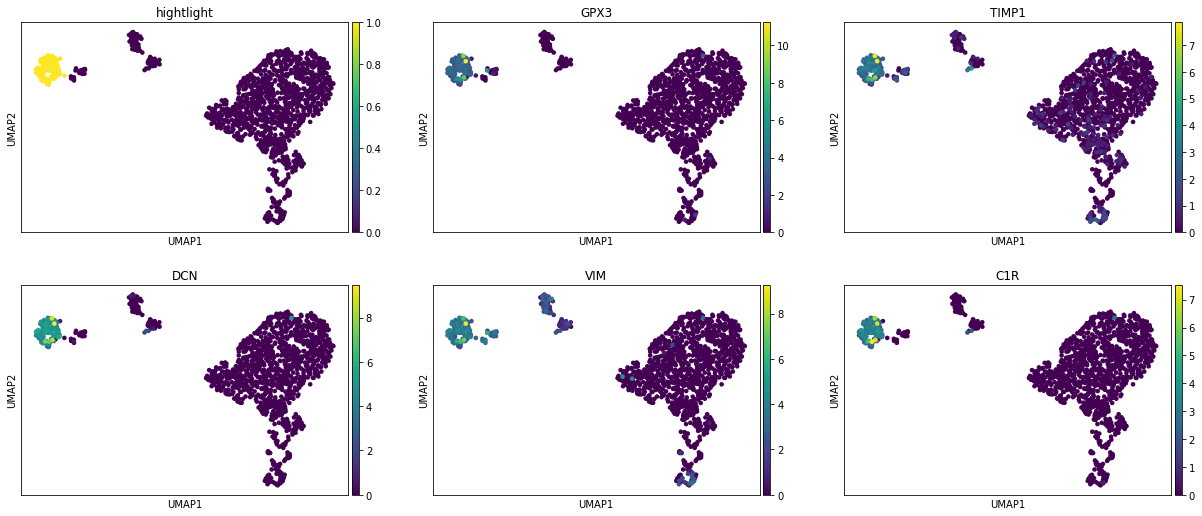

2


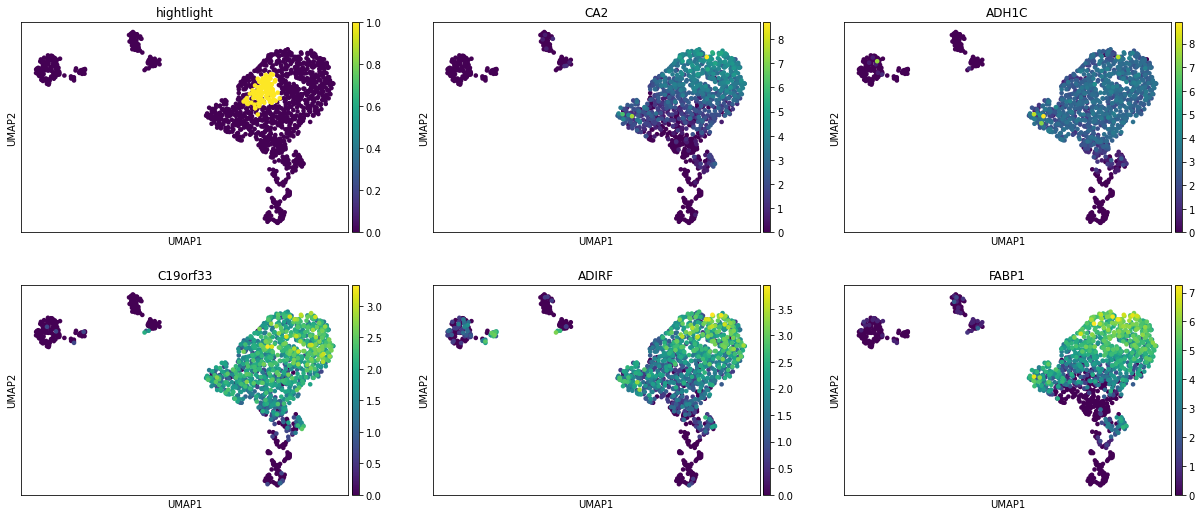

3


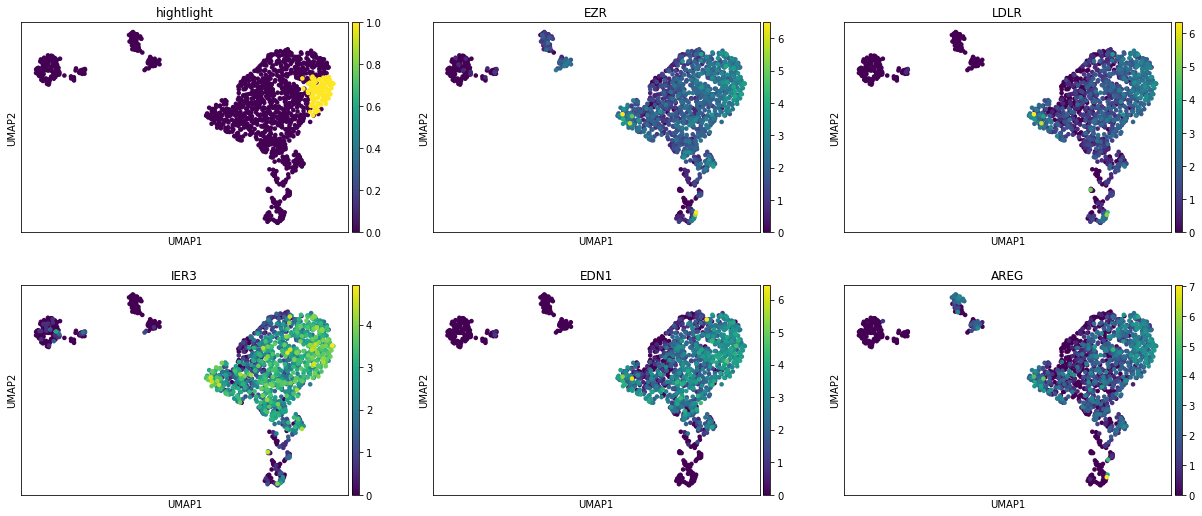

4


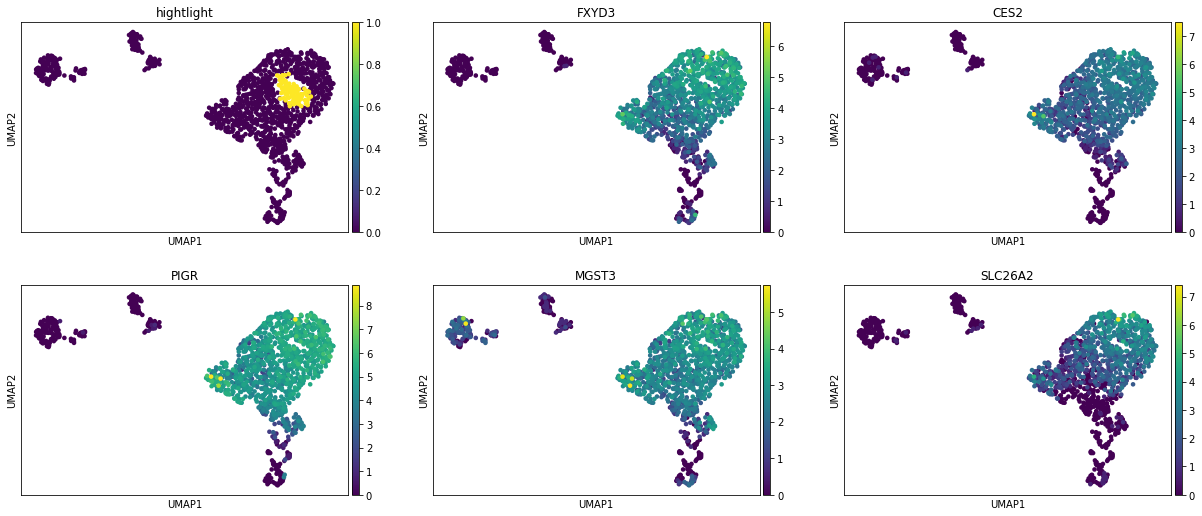

5


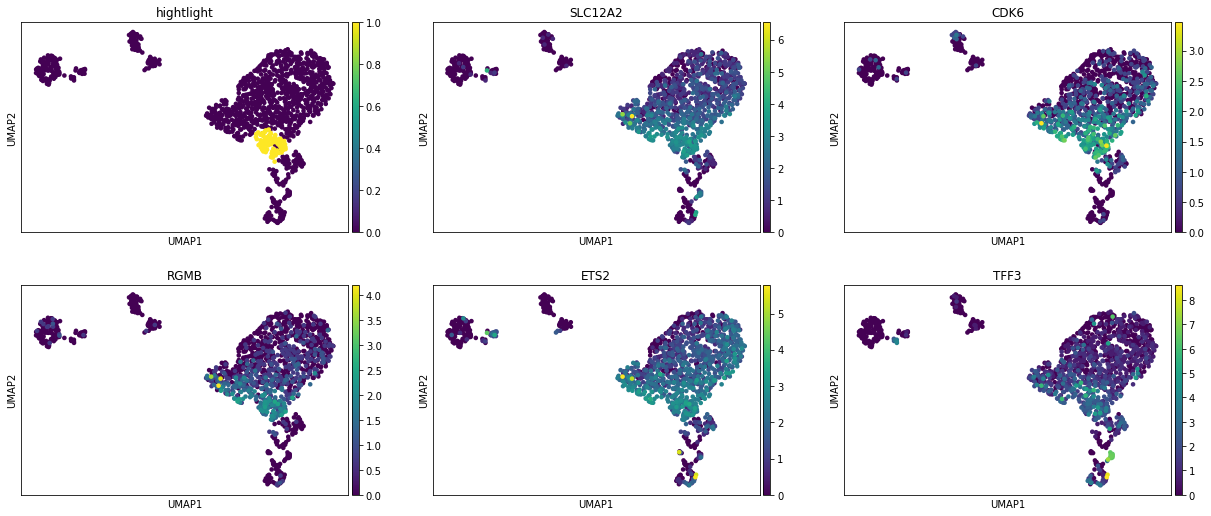

6


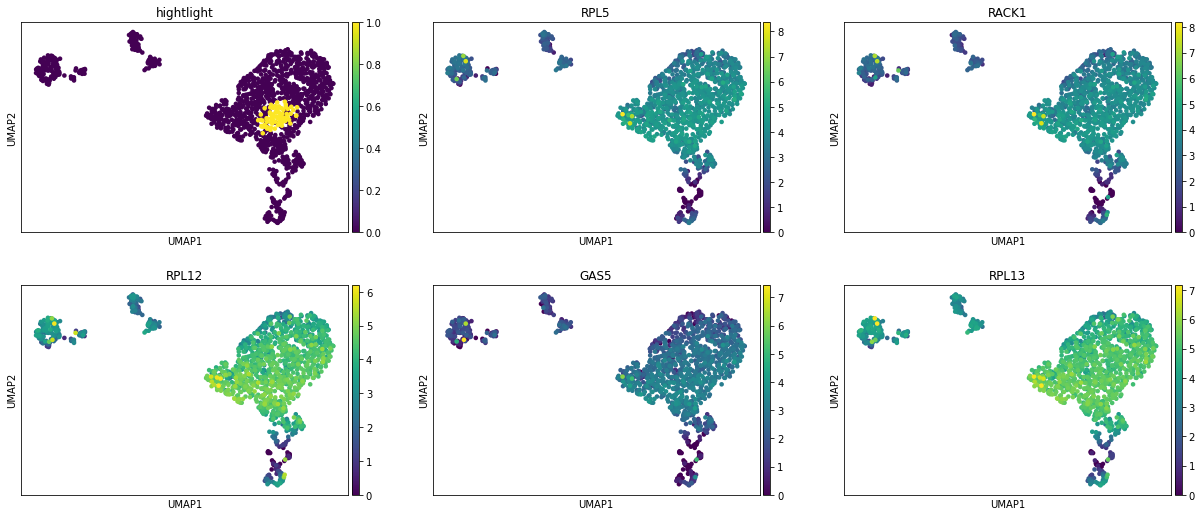

7


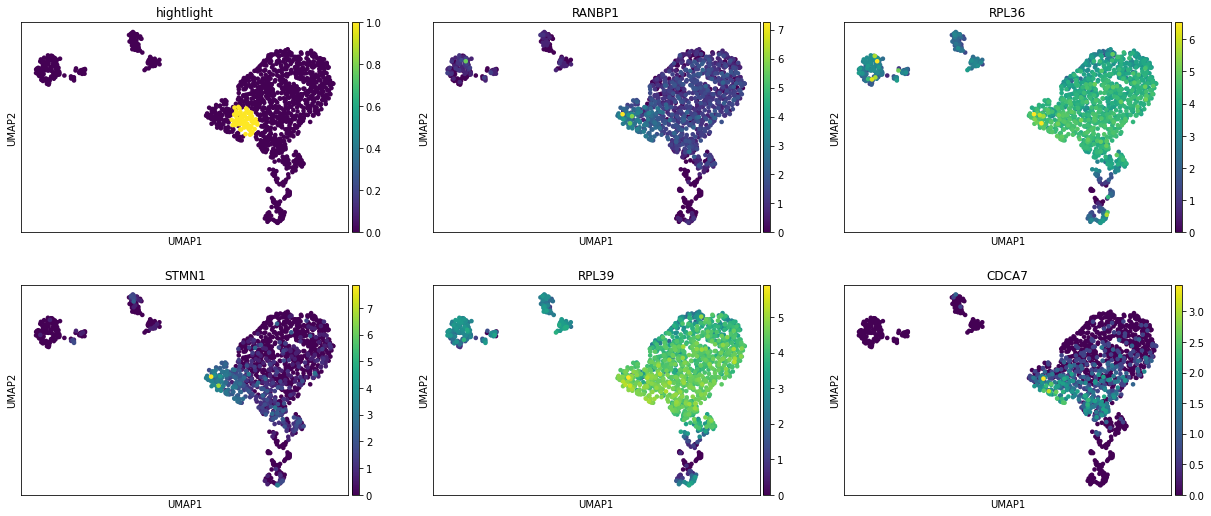

8


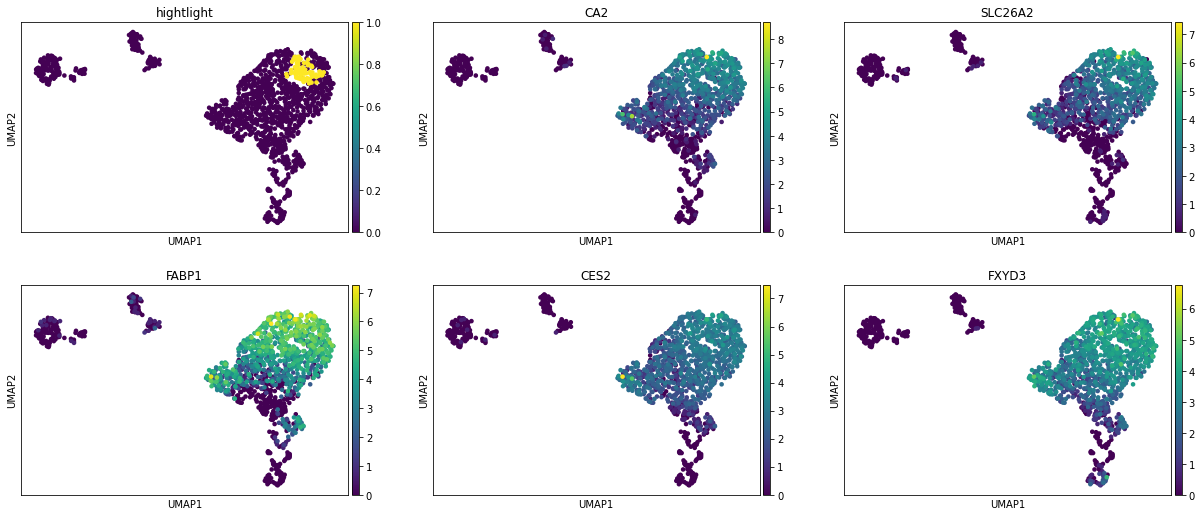

9


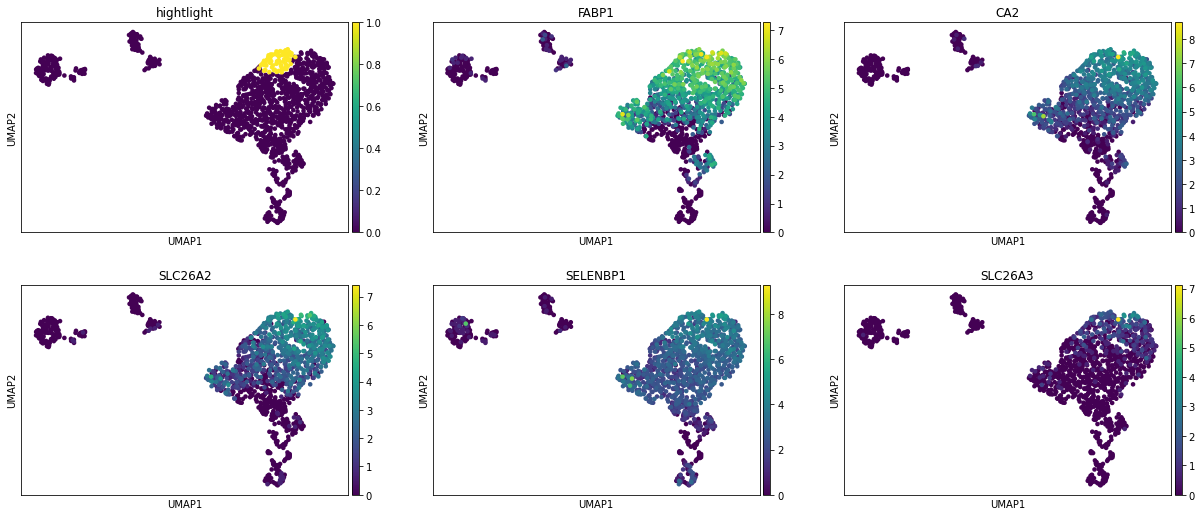

10


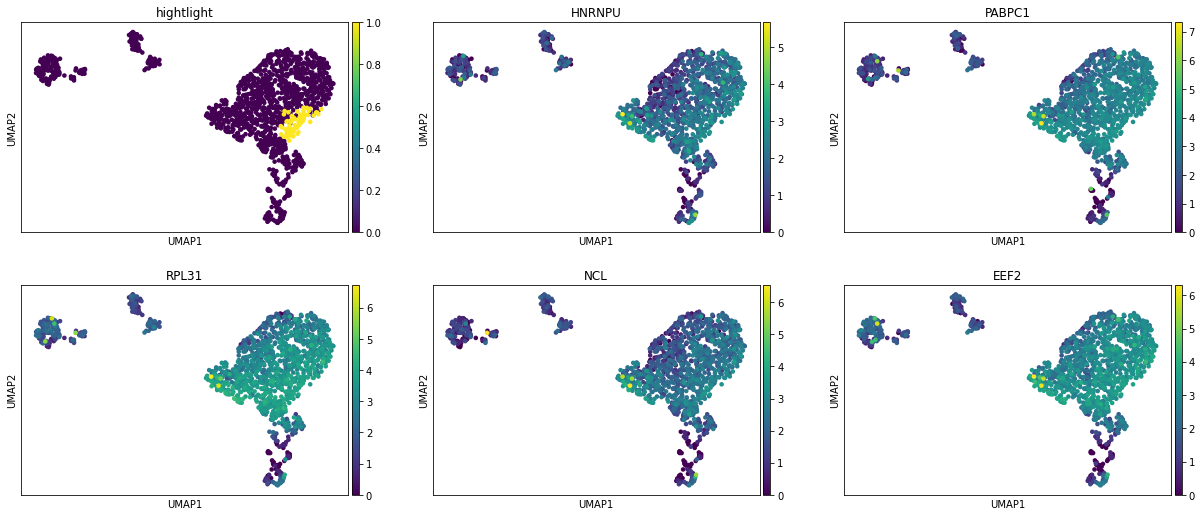

11


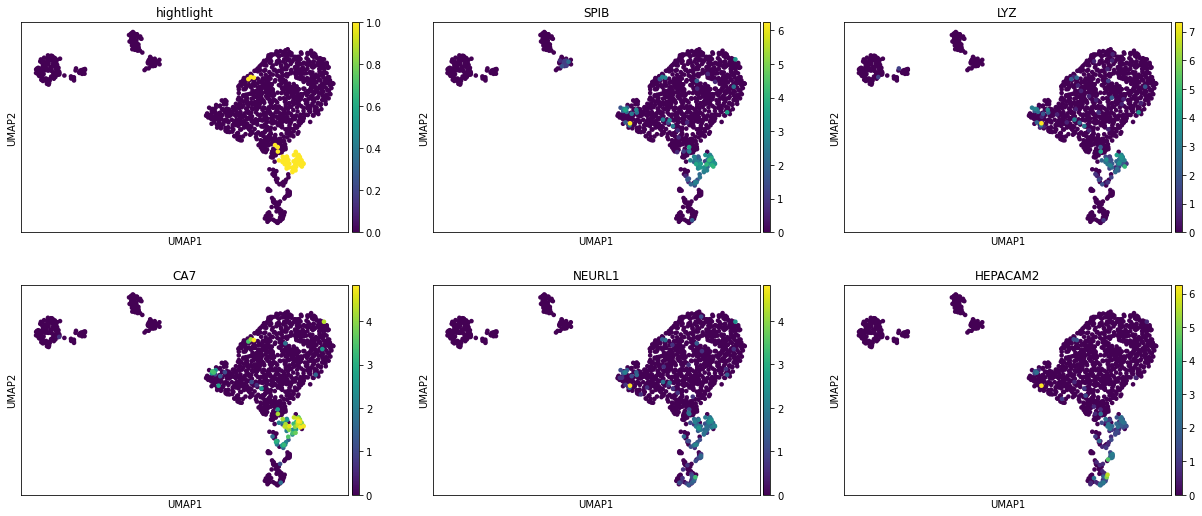

12


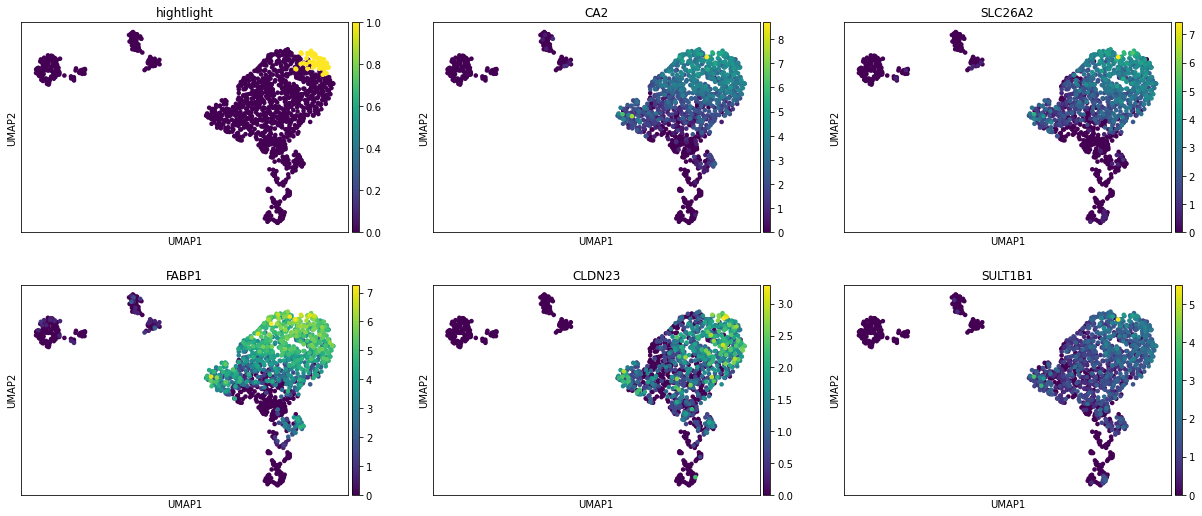

13


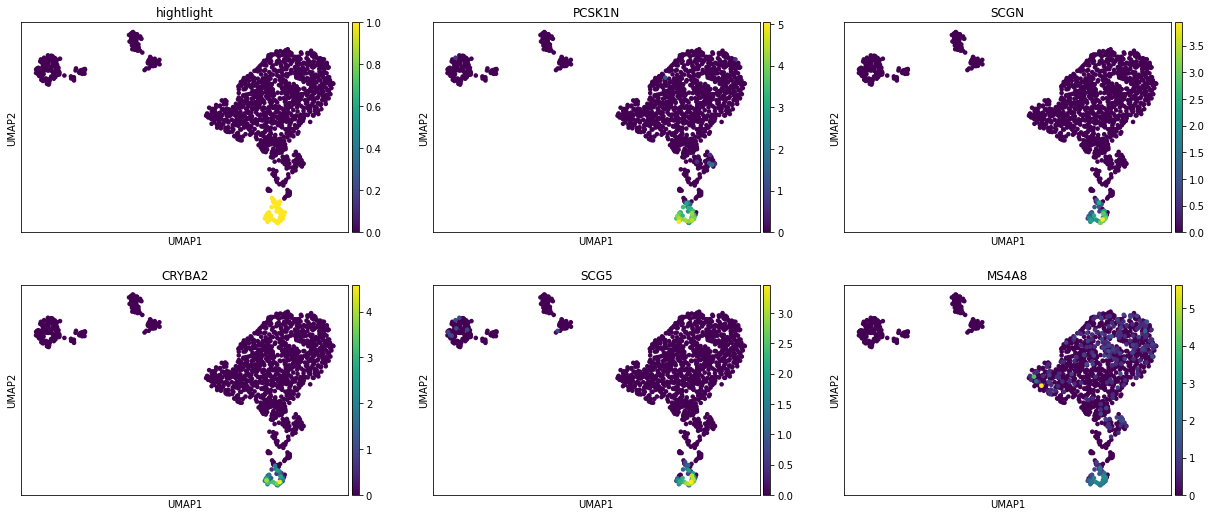

14


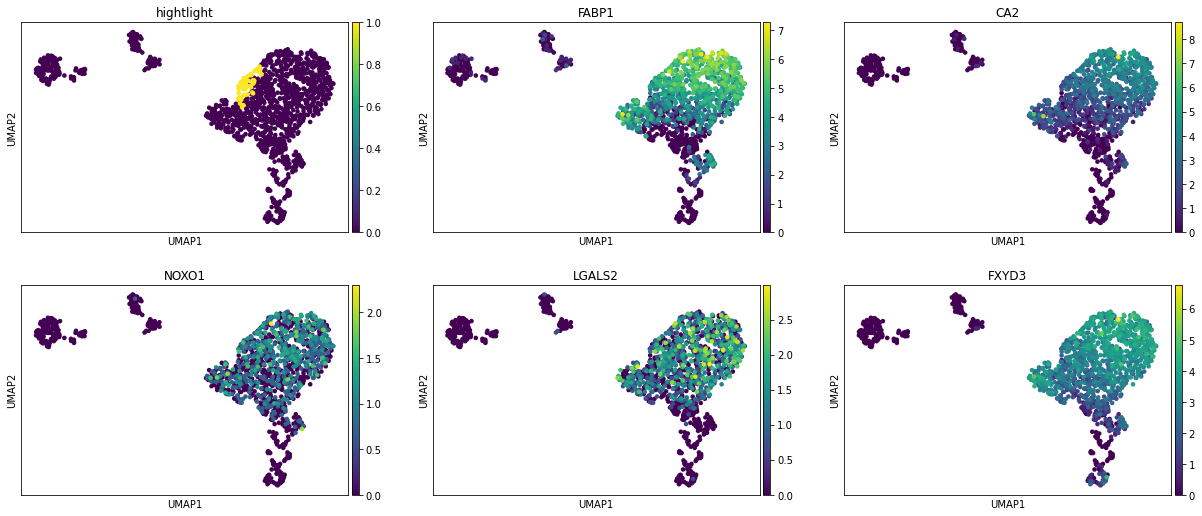

15


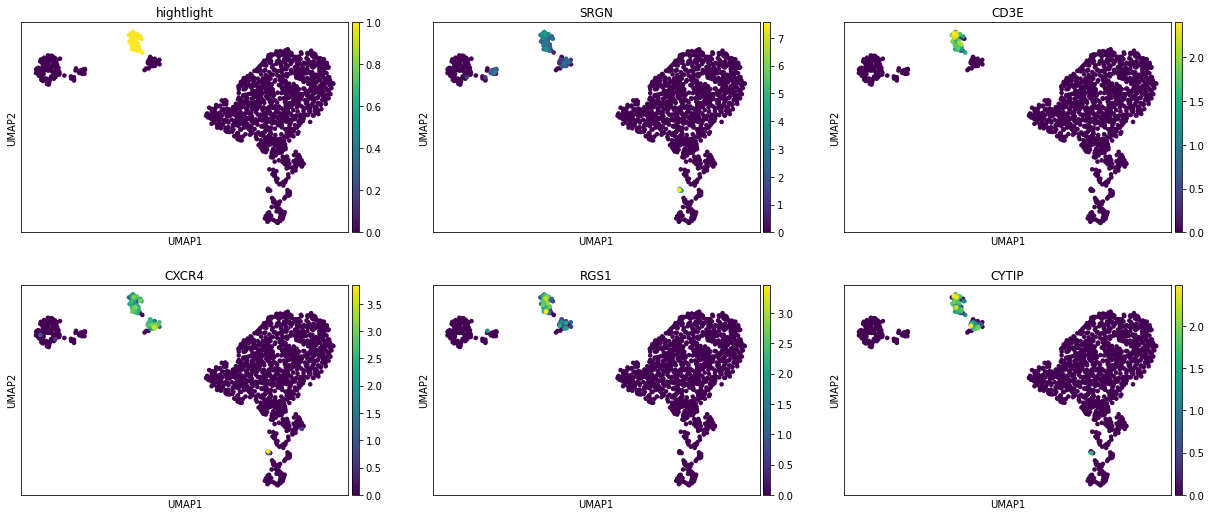

16


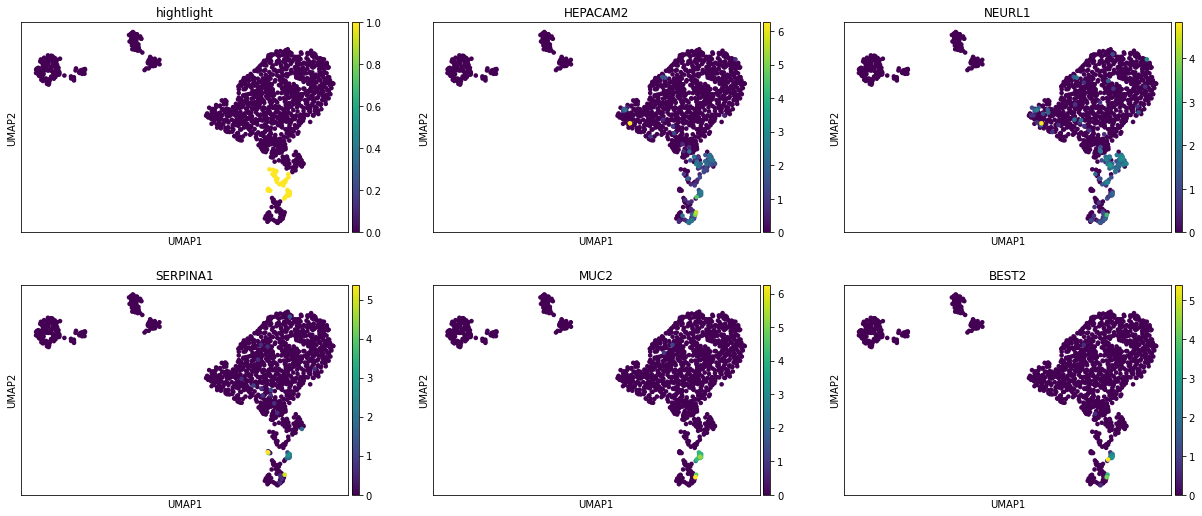

17


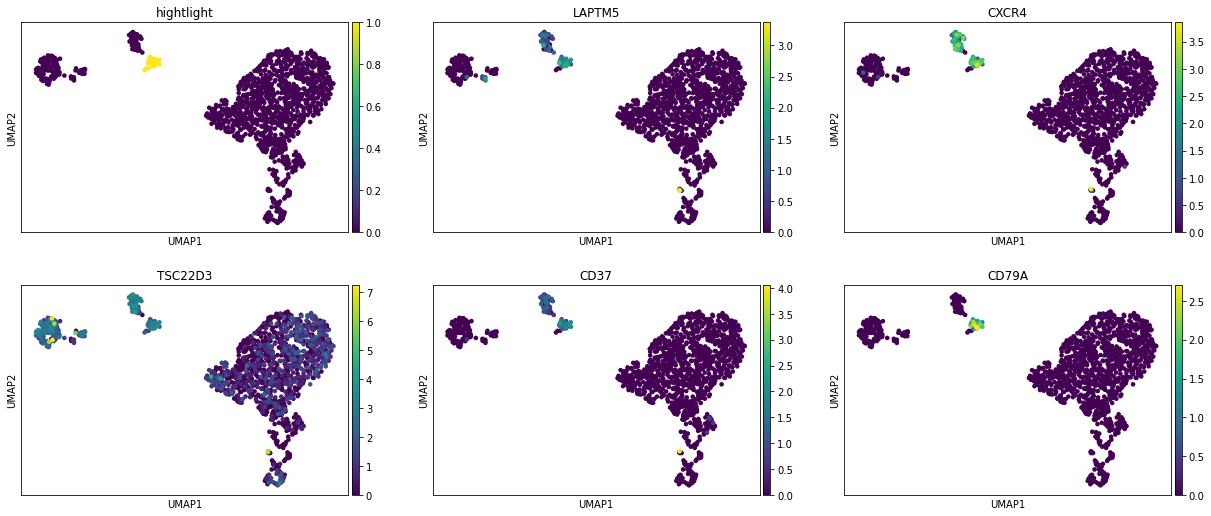

18


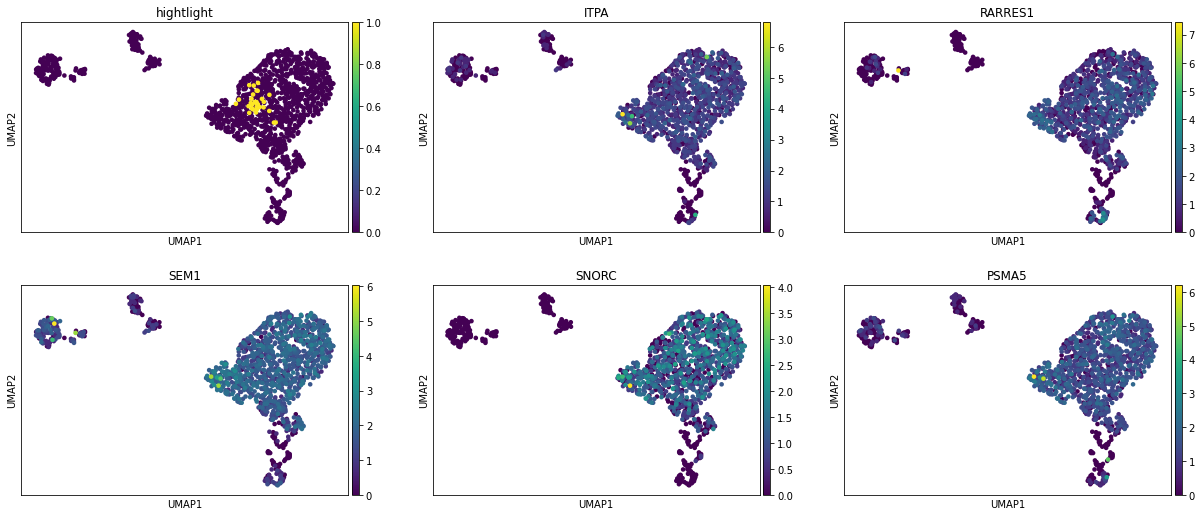

19


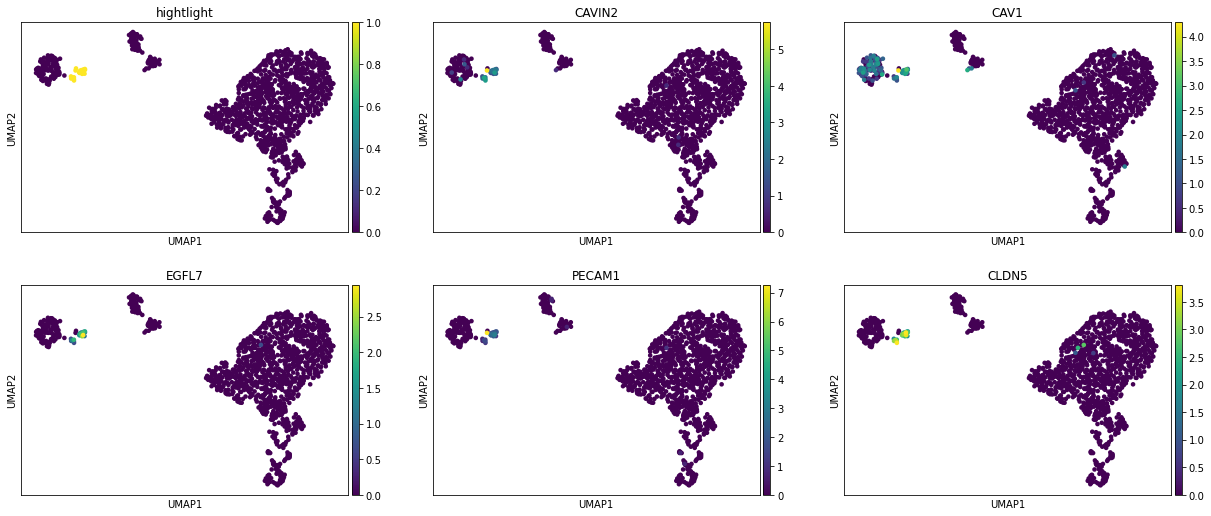

20


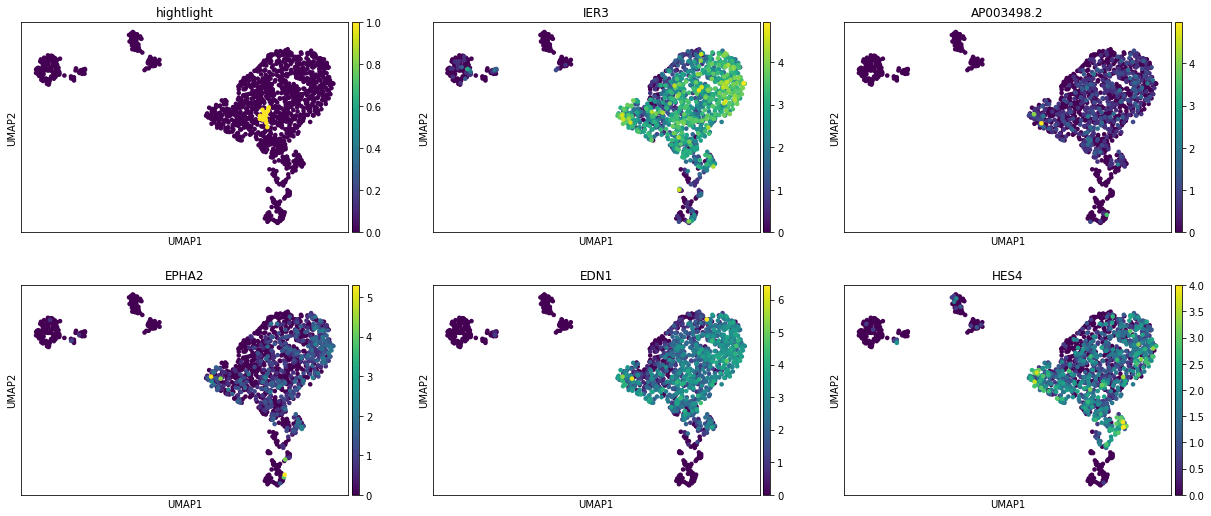

In [28]:
for x in DE.keys():
    print(x)
    topgenes = list(DE[x].T[:5].index)
    organ_adata.obs["hightlight"] = organ_adata.obs["leiden"] == x
    sc.pl.umap(
        organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

### The extended DE list can be queried by 

In [29]:
DE["0"].T

wilcoxon_score  log fold change  adjusted pvalue
TUBA1B       16.307011         3.670423     3.002724e-55
STMN1        16.297977         4.771872     3.002724e-55
H2AFZ        16.066078         3.386778     8.656378e-54
TUBB         15.515867         3.411469     3.987722e-50
HMGB2        15.435991         3.796591     1.103793e-49
...                ...              ...              ...
CDKN1C       -2.025524        -2.352805     3.580669e-01
TFPI         -2.199776        -3.876692     2.439935e-01
ANXA1        -2.390787       -27.810825     1.547679e-01
VIM          -2.685208        -2.739498     7.226381e-02
TUBA1A       -2.757476        -3.600853     5.945131e-02

[58870 rows x 3 columns]

# read in cell ontology 

In [30]:
import obonet

ont_dir = "/data/yosef2/users/chenling/TabulaSapiensData/ontology/"
obo = ont_dir + "cl.obo.txt"
f = open(obo, "r")
co = obonet.read_obo(f)
f.close()

celltype_dict = {}
for x in co.nodes:
    celltype_dict[co.nodes[x]['name']] = x



You can look up all T cell by typing celltype_dict['T'] and using tab complete  

In [31]:
celltype_dict["T cell"]

'CL:0000084'

You can also look at the names of all subsets of T cell that contains 'CD4' in their names

In [32]:
import networkx as nx


def PrintChildren(co, parent, pattern=""):
    all_children = [x for x in nx.ancestors(co, celltype_dict[parent])]
    return [co.nodes[x]["name"] for x in all_children if pattern in co.nodes[x]["name"]]


PrintChildren(co, "T cell", "CD4")

['CD4-negative, CD8-negative type I NK T cell secreting interleukin-4',
 'CD24-positive, CD4 single-positive thymocyte',
 'activated CD4-positive type I NK T cell',
 'central memory CD4-positive, alpha-beta T cell',
 'CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell',
 'CD4-positive type I NK T cell secreting interferon-gamma',
 'activated CD4-positive, CD25-positive, CCR4-positive, alpha-beta regulatory T cell, human',
 'CD4-positive, CD25-positive, alpha-beta regulatory T cell',
 'CD4-negative, CD8-negative type I NK T cell',
 'effector CD4-positive, alpha-beta T cell',
 'CD4-negative, CD8-negative type I NK T cell secreting interferon-gamma',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-positive, alpha-beta T cell',
 'CD2-positive, CD5-positive, CD44-positive alpha-beta intraepithelial T cell',
 'CD4-positive helper T cell',
 'CD4-positive, CD8-intermediate double-positive thymocyte',
 'CD4-positive, alpha-beta thymocyte',
 'CD4-positive, alpha-beta me

# manually create mapping between cluster and cell type (this is just an example), and the relevant marker genes that was used to generate this prediction

In [33]:
organ_adata.obs["annotation_oct2020"] = organ_adata.obs["leiden"].copy()
cluster_mapping = {"0": "T cell"}
cluster_markers = {"0": ["CXCR4", "CD3D", "IL7R", "IL32"]}

This cell will automatically replace the leiden cluster names with cell type annotations

In [34]:
for l in cluster_mapping.keys():
    organ_adata.obs["annotation_oct2020"].replace(l, cluster_mapping[l], inplace=True)
    display(DE[l][cluster_markers[l]])

CXCR4       CD3D       IL7R      IL32
wilcoxon_score   -1.074511  -0.308922  -0.496961 -0.639952
log fold change -27.103447 -24.655876 -26.039459 -1.199680
adjusted pvalue   1.000000   1.000000   1.000000  1.000000

# Visualize the results of the manual annotation

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



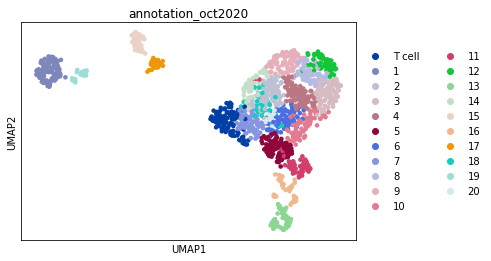

In [35]:
sc.pl.umap(
    organ_adata,
    color=["annotation_oct2020"],
    ncols=3,
)

# create celltype subcluster
This is just an example once the celltype annotations are done, how to subcluster cells in a celltype

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead

/data/yosef2/users/chenling/miniconda3/envs/scvi-tools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



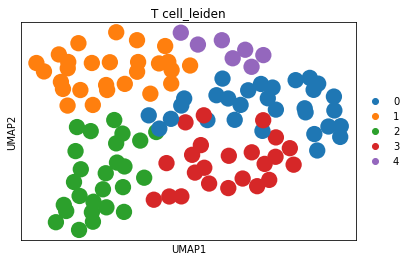

In [36]:
celltype = "T cell"
sub_organ_adata = organ_adata[organ_adata.obs["annotation_oct2020"] == celltype]
sc.pp.neighbors(sub_organ_adata, use_rep="X_scvi_decontX")
sc.tl.umap(
    sub_organ_adata,
)
sc.tl.leiden(sub_organ_adata, resolution=1, key_added="%s_leiden" % celltype)
sc.pl.umap(
    sub_organ_adata,
    color=["%s_leiden" % celltype],
    ncols=3,
)

In [37]:
sc.tl.rank_genes_groups(
    sub_organ_adata, groupby="%s_leiden" % celltype, method="wilcoxon"
)
sub_DE = FormatDE(sub_organ_adata.uns["rank_genes_groups"])

0


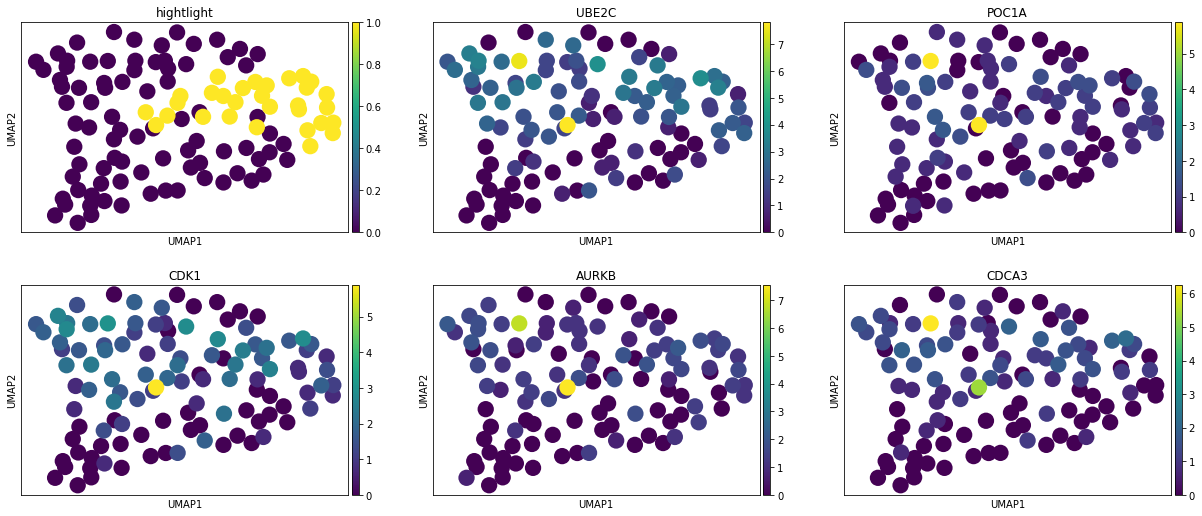

1


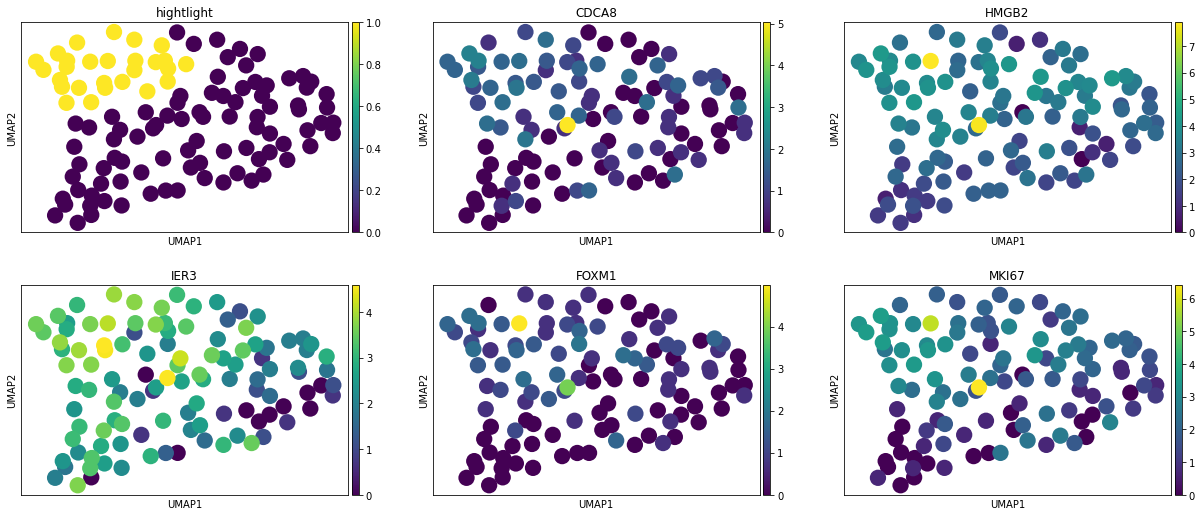

2


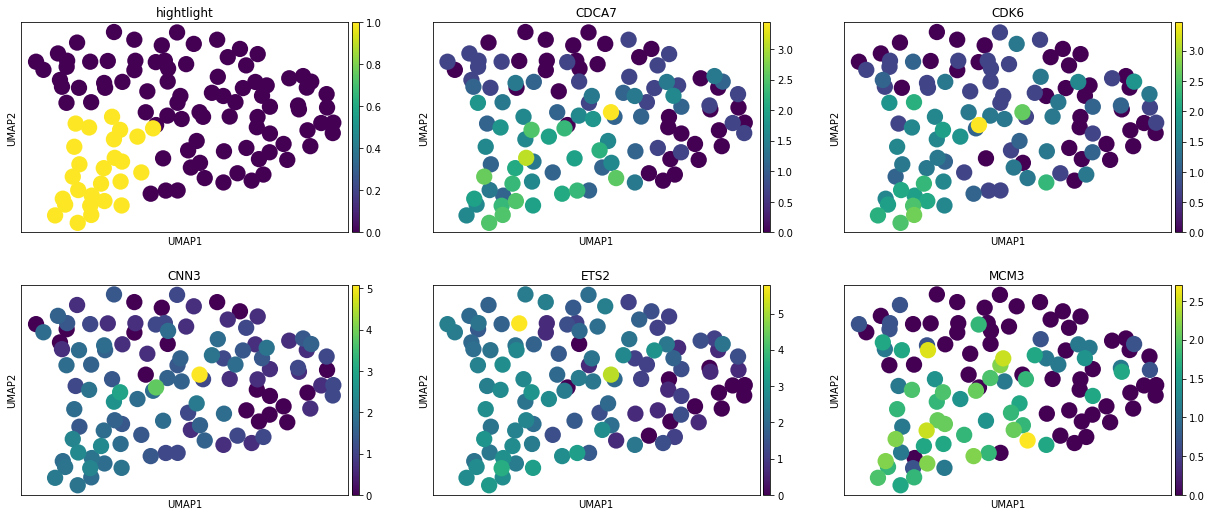

3


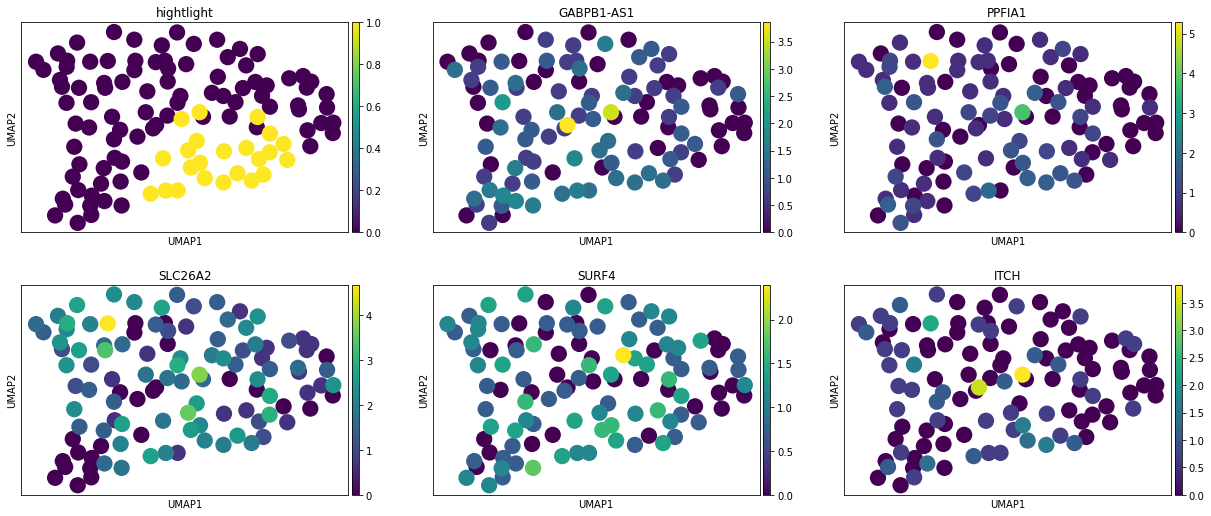

4


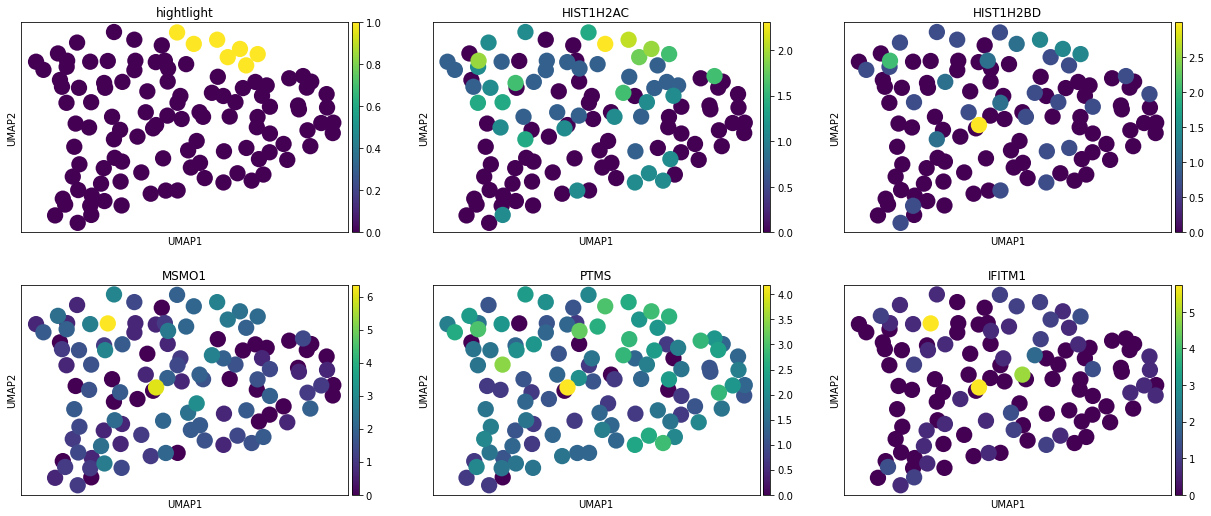

In [38]:
for x in sub_DE.keys():
    print(x)
    topgenes = list(sub_DE[x].T[:5].index)
    sub_organ_adata.obs["hightlight"] = sub_organ_adata.obs["%s_leiden" % celltype] == x
    sc.pl.umap(
        sub_organ_adata,
        color=["hightlight"] + topgenes,
        ncols=3,
    )

# manually create mapping between cell type and compartment (this is just an example)

In [39]:
organ_adata.obs["compartment_oct2020"] = organ_adata.obs["annotation_oct2020"].copy()
compartment_mapping = {"T cell": "Immune"}

This cell will automatically replace the leiden cluster names with cell type annotations

In [40]:
for c in compartment_mapping.keys():
    organ_adata.obs["compartment_oct2020"].replace(
        c, compartment_mapping[c], inplace=True
    )

# Visualize the results of the new compartment splitting

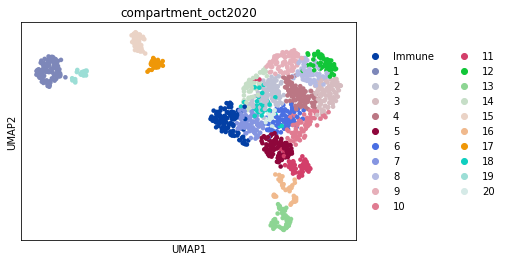

In [41]:
sc.pl.umap(
    organ_adata,
    color=["compartment_oct2020"],
    ncols=3,
)

# save data

In [42]:
organ_adata.write_h5ad(
    data_path + "decontX/organ_data/Pilot1_Pilot2.decontX.%s.h5ad" % organ
)